# PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle

## 0. Описание кейса и постановка задачи

Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, *которая предсказывает рейтинг отеля*. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Вы будете работать с датасетом, в котором содержатся сведения о 515 000 отзывов на отели Европы. Модель, которую вы будете обучать, должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных. Изученные нами навыки разведывательного анализа помогут улучшить модель.

Первоначальная версия датасета содержит 17 полей со следующей информацией:

- hotel_address — адрес отеля;
- review_date — дата, когда рецензент разместил соответствующий отзыв;
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- hotel_name — название отеля;
- reviewer_nationality — страна рецензента;
- negative_review — отрицательный отзыв, который рецензент дал отелю;
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
- positive_review — положительный отзыв, который рецензент дал отелю;
- review_total_positive_word_counts — общее количество слов в положительном отзыве.
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
- total_number_of_reviews — общее количество действительных отзывов об отеле;
- tags — теги, которые рецензент дал отелю;
- days_since_review — количество дней между датой проверки и датой очистки;
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- lat — географическая широта отеля;
- lng — географическая долгота отеля.

## 1. Подготовка к работе

### 1.1. Импорт библиотек

In [1]:
import os
import pandas as pd
import numpy as np

# Для подсчёта тэгов
from collections import Counter

# Загружаем специальный инструмент для разбивки данных:  
from sklearn.model_selection import train_test_split

# Импортируем необходимые библиотеки:
# для шкалирования
from sklearn import preprocessing
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
# инструменты для оценки точности модели
from sklearn import metrics
# Сравнение выборок
from sklearn.feature_selection import f_classif # anova

# Для анализа тональности текста
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time

# Нормализация
from scipy.stats import normaltest

# библиотека для логирования эксперимента
from comet_ml import Experiment

# Библиотеки визуализации
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Установка параметров визуализации
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
sns.set_theme(style='darkgrid')

# Собственный модуль обработки данных
from eda import *

# Импорт переменных окружения
from decouple import config

# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

### 1.2. Эксперимент и константы

**Запуск эксперимента**

In [2]:
# Нужно ли логирование в Comet
save_experiment = False # config('SAVE_EXPERIMENT', default=False, cast=bool)

if save_experiment:
    experiment = Experiment(
        api_key=config('COMET_API',default=''),
        project_name='booking-reviews',
        workspace='mvulf'
    )

**Константы обучения**

In [3]:
TEST_SIZE = 0.25
RANDOM_STATE = 42
N_ESTIMATORS = 100
TARGET_NAME = 'reviewer_score'

if 'experiment' in locals():
    # Логируем применяемые параметры
    params = {
        'test_size': TEST_SIZE,
        'random_state': RANDOM_STATE,
        'n_estimators': N_ESTIMATORS,
        'target_name': TARGET_NAME
    }
    experiment.log_parameters(params)

### 1.3. Загрузка данных

In [4]:
# Загрузим данные для обучения
df_train_test = pd.read_csv('input/hotels_train.csv')
display(df_train_test.info())
df_train_test.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   

                        hotel_name reviewer_nationality  negative_review  \
0               The May Fair Hotel      United Kingdom          Leaving    
1  Mercure London Bloomsbury Hotel      United Kingdom    poor breakfast   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                  3                     1994   
1                                  3                     1361   

       positive_review  review_total_positive_word_counts  \
0   Staff were amazing                                  4   
1             location                                  2   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   

         lat       lng  
0  51.507894 -0.143671  
1  51.521009 -0.123097

In [5]:
# Загрузим тестовые данные
df_predict = pd.read_csv('input/hotels_test.csv')
display(df_predict.info())
df_predict.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

None

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   

   additional_number_of_scoring review_date  average_score         hotel_name  \
0                           904   7/21/2017            8.1     Hotel Da Vinci   
1                           612  12/12/2016            8.6  Urban Lodge Hotel   

  reviewer_nationality                                    negative_review  \
0      United Kingdom    Would have appreciated a shop in the hotel th...   
1             Belgium         No tissue paper box was present at the room   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   

         lat       lng  
0  45.533137  9.171102  
1  52.385649  4.834443

In [6]:
# Загрузим файл для отправки на оценку
sample_submission = pd.read_csv('input/submission.csv')
display(sample_submission.info())
sample_submission.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


None

reviewer_score      id
0               1  488440
1              10  274649

### 1.4. Объединение train_test и predict

Объединение необходимо для совместной обработки двух датасетов

In [7]:
df_train_test['sample'] = 1 # пометили данные для train и test
df_predict['sample'] = 0 # пометили данные для финального предсказания predict
# в тесте у нас нет значения reviewer_score, мы его должны предсказать, 
# поэтому пока просто заполняем нулями
df_predict['reviewer_score'] = 0

# Объединяем датасеты для работы
# первым идёт df_test, чтобы индексация совпала с submition
data = pd.concat([df_predict, df_train_test]).reset_index(drop=True)

## 2. Предварительный анализ и подготовка данных

Включает в себя:
- **Предварительный анализ данных (data understanding)** с составлением 
рекомендаций для подготовки данных;
- **Подготовку и очистку данных (data preparation & cleaning)**.
Очистка данных представляет собой:
    - удаление/разметка дубликатов
    - заполнение пропусков
    - удаление/разметка выбросов и аномалий;
- **Создание новых признаков (feature generating)**. 
Часть проектирования признаков (feature engineering, раздел 3). 
Реализуется дополнением внешними данными и комбинацией признаков. 

Последние два пункта частично объединены в этом проекте,
так как создаваемые признаки позволят заполнить пропуски. 


### Предварительный анализ данных (data understanding) 

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Посмотрим на количество уникальных значений

In [9]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

**Note**: 
- Явные пропуски содержатся в колонках долготы и широты местоположения 
отеля (lat & lng).
- В числовом формате данные хранятся в 9 из 16 столбцах. 
Необходимо рассмотреть возможность извлечения полезных признаков.
- Для категориальных признаков будем вводить 'other' для редких значений 
с целью сокращения количества уникальных значений


Более подробный анализ признаков проводится далее

### Подготовка и очистка данных, создание новых признаков (data preparation & cleaning, feature generating)

#### **hotel_address**->*hotel_country & hotel_city* и **hotel_name**(*edit*)

In [10]:
sum(data['hotel_name'].str.contains('H tel'))

14110

В имени некоторых дефектов содержатся пропуски, исправим их

Оценим количество отелей в данных

In [11]:
# Удалим пробелы
data['hotel_address'] = data['hotel_address'].str.strip()
data['hotel_name'] = data['hotel_name'].str.strip()
# Исключим дефекты в имени отеля
data['hotel_name'] = data['hotel_name'].str.replace('H tel', 'Hotel')

print(f"Количество уникальных адресов отелей: {data['hotel_address'].nunique()}")
print(f"Количество уникальных имён отелей: {data['hotel_name'].nunique()}")

Количество уникальных адресов отелей: 1493
Количество уникальных имён отелей: 1491


Похоже, что на одно название отеля приходится 2 адреса. Определим, что это за отель.

In [12]:
# Сгруппируем по именам отелей и определим уникальные адреса
hotels_addresses = data.groupby(by='hotel_name')['hotel_address'].nunique()
# Проанализируем количество уникальных адресов для каждого отеля
n_hotels_addresses = hotels_addresses.sort_values(ascending=False)
n_hotels_addresses

hotel_name
Hotel Regina                             4
11 Cadogan Gardens                       1
Mercure Paris Gare Montparnasse          1
Mercure Paris Opera Louvre               1
Mercure Paris Opera Grands Boulevards    1
                                        ..
Hotel Balmoral                           1
Hotel Balmes                             1
Hotel Bagu s                             1
Hotel Bachaumont                         1
pentahotel Vienna                        1
Name: hotel_address, Length: 1491, dtype: int64

Таким образом, мы видим, что только у "Hotel Regina" имеется несколько уникальных адресов. Посмотрим на эти адреса

In [13]:
# Извлечём название отеля с несколькими адресами
frequent_hotel = n_hotels_addresses.index[0]

# Проанализируем адреса этого отеля
frequent_hotel_addresses = list(data[data['hotel_name'] == frequent_hotel]\
    ['hotel_address'].unique())
print(f'Адреса отеля {frequent_hotel}: {frequent_hotel_addresses}')

Адреса отеля Hotel Regina: ['2 place des Pyramides 1st arr 75001 Paris France', 'Bergara 2 4 Eixample 08002 Barcelona Spain', 'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria', 'Via Cesare Correnti 13 Milan City Center 20123 Milan Italy']


У "Hotel Regina" есть 3 адреса в различных странах: Испания, Италия и Австрия.

При этом число уникальных названий отелей и уникальных адресов отличается только на 1 в пользу адреса. Можно предположить, что есть дублирование адреса. Проверим.

In [14]:
# Сгруппируем по адресам отелей и определим уникальные имена
hotels_names = data.groupby(by='hotel_address')['hotel_name'].nunique()
# Проанализируем количество уникальных имён для каждого адреса
n_hotels_names = hotels_names.sort_values(ascending=False)
n_hotels_names.head(5)

hotel_address
8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom                2
1 15 Templeton Place Earl s Court Kensington and Chelsea London SW5 9NB United Kingdom    1
Hernalser Hauptstra e 187 17 Hernals 1170 Vienna Austria                                  1
Hoffingergasse 26 28 12 Meidling 1120 Vienna Austria                                      1
Hobbemakade 50 Oud Zuid 1071 XL Amsterdam Netherlands                                     1
Name: hotel_name, dtype: int64

Таким образом, есть адрес, по которому зарегистрировано 2 отеля. Посмотрим на названия отелей.

In [15]:
# Извлечём адрес с несколькими отелями
frequent_address = n_hotels_names.index[0]

# Проанализируем отели одного адреса
frequent_address_hotels = list(data[data['hotel_address'] ==\
    frequent_address]['hotel_name'].unique())
print(f'Названия отелей по адресу {frequent_address}: {frequent_address_hotels}')

Названия отелей по адресу 8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom: ['Club Quarters Hotel Trafalgar Square', 'The Grand at Trafalgar Square']


Проверка с помощью онлайн-карт google подтвердила, что по одному адресу зарегистрированы 2 отеля.

Посмотрим на частоту отзывов отелей:

In [16]:
display(data.groupby(by=['hotel_name','hotel_address'])['review_date']\
    .count().sort_values(ascending=True).reset_index().head(1200))
display(data.groupby(by=['hotel_name','hotel_address'])['review_date']\
    .count().sort_values(ascending=False).reset_index().head(300))

hotel_name  \
0               Hotel Gallitzinberg   
1     Mercure Paris Porte d Orleans   
2                      Hotel Wagner   
3      Ibis Styles Milano Palmanova   
4                Hotel Daniel Paris   
...                             ...   
1195              Hotel Prinz Eugen   
1196                   Hotel Mozart   
1197  Worldhotel Cristoforo Colombo   
1198    Ace Hotel London Shoreditch   
1199         H10 Metropolitan 4 Sup   

                                          hotel_address  review_date  
0     Johann Staud Stra e 32 16 Ottakring 1160 Vienn...            8  
1                13 Rue Fran ois Ory 92120 Paris France           10  
2     Via M Buonarroti 13 Fiera Milano City 20149 Mi...           10  
3                   Via Palmanova 153 20132 Milan Italy           12  
4     8 rue Fr d ric Bastiat 8th arr 75008 Paris France           12  
...                                                 ...          ...  
1195    Wiedner G rtel 14 04 Wieden 1040 Vienna Austria          511  
1196    Piazza Gerusalemme 6 Sempione 20154 Milan Italy          512  
1197  Corso Buenos Aires 3 Milan City Center 20124 M...          512  
1198  100 Shoreditch High Street Hackney London E1 6...          514  
1199  Rambla Catalunya 7 9 Eixample 08007 Barcelona ...          514  

[1200 rows x 3 columns]

hotel_name  \
0           Britannia International Hotel Canary Wharf   
1                                  Strand Palace Hotel   
2                 Park Plaza Westminster Bridge London   
3               Copthorne Tara Hotel London Kensington   
4    DoubleTree by Hilton Hotel London Tower of London   
..                                                 ...   
295                             H10 Metropolitan 4 Sup   
296                                       Hotel Mozart   
297                      Worldhotel Cristoforo Colombo   
298                                   Hotel Capricorno   
299                                  Hotel Prinz Eugen   

                                         hotel_address  review_date  
0    163 Marsh Wall Docklands Tower Hamlets London ...         4789  
1    372 Strand Westminster Borough London WC2R 0JJ...         4256  
2    Westminster Bridge Road Lambeth London SE1 7UT...         4169  
3    Scarsdale Place Kensington Kensington and Chel...         3578  
4    7 Pepys Street City of London London EC3N 4AF ...         3212  
..                                                 ...          ...  
295  Rambla Catalunya 7 9 Eixample 08007 Barcelona ...          514  
296    Piazza Gerusalemme 6 Sempione 20154 Milan Italy          512  
297  Corso Buenos Aires 3 Milan City Center 20124 M...          512  
298  Schwedenplatz 3 4 01 Innere Stadt 1010 Vienna ...          511  
299    Wiedner G rtel 14 04 Wieden 1040 Vienna Austria          511  

[300 rows x 3 columns]

In [17]:
predict_names = set(df_predict['hotel_name'].unique())
train_test_names = set(df_train_test['hotel_name'].unique())

if train_test_names == predict_names:
    print('И обучающая, и предсказательная выборки имён отелей одинаковы')

И обучающая, и предсказательная выборки имён отелей одинаковы


**Note**:
- При генерации признаков из полного адреса можно извлечь город и страну расположения отеля.
- К имени 'Hotel Regina' можно добавить страну расположения отеля.
- В обоих исходных датасетах представлены одни и те же отели
- Нужен ли нам для обучения такой признак, как имя отеля?

Если нужен, то в дальнейшем может потребоваться уменьшить количество уникальных названий отеля, введя категорию other_name для остальных названий. *Например, при сокращении до 300 уникальных имён отелей по количеству отзывов.* Тем не менее, данный признак очень похож на неинформативный из-за слишком большого количества уникальных имён.
- Скорее всего, признак имени стоит исключить из обучения как по причине неинформативности, так и с точки зрения конечной цели создания модели - необходимо предотвращать накрутку рейтингов нечестными отелями. Проверка будет осуществляться самых разных отелей, различной популярности, в том числе и малопопулярных. Название само по себе малополезно, так как у нас уже есть сведения об общем количестве оставленных отзывов каждому из отелей.
- Можно оценить влияние количества слов в названии на медианную оценку - есть ли оно?

**Извлечём страну и город каждого из отелей**

In [18]:
print('Посмотрим на последнее слово в адресе, '+\
    'которое должно представлять собой страну:')
data['hotel_address'].apply(lambda x: x.split()[-1]).unique()

Посмотрим на последнее слово в адресе, которое должно представлять собой страну:


array(['Italy', 'Netherlands', 'Spain', 'Kingdom', 'France', 'Austria'],
      dtype=object)

Видим, что Страны однословные, за исключением Великобритании. Учтём это.

In [19]:
# Учтём двусловность United Kingdom
data['hotel_country'] = data['hotel_address'].apply(lambda x:\
    x.split()[-1] if x.split()[-1] != 'Kingdom' else ' '.join(x.split()[-2:]))
print('Представленные в датасете страны:')
print(data['hotel_country'].unique())

Представленные в датасете страны:
['Italy' 'Netherlands' 'Spain' 'United Kingdom' 'France' 'Austria']


Посмотрим на города отелей из Великобритании

In [20]:
data[data['hotel_country'] == 'United Kingdom']['hotel_address'].unique()

array(['Coram Street Camden London WC1N 1HT United Kingdom',
       'Empire Way Wembley Brent London HA9 8DS United Kingdom',
       '1 Shortlands Hammersmith and Fulham London W6 8DR United Kingdom',
       '49 Gloucester Place Marble Arch Westminster Borough London W1U 8JE United Kingdom',
       '101 Buckingham Palace Road Westminster Borough London SW1W 0SJ United Kingdom',
       '30 Portman Square Westminster Borough London W1H 7BH United Kingdom',
       '81 103 Euston Street Camden London NW1 2EZ United Kingdom',
       '34 Lombard Road Battersea London SW11 3RF United Kingdom',
       '30 Jamestown Road Camden London NW1 7BY United Kingdom',
       '52 Chiswell Street City of London London EC1Y 4SD United Kingdom',
       'Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom',
       '130 135 Minories City of London London EC3N 1NU United Kingdom',
       '4 18 Harrington Gardens Kensington and Chelsea London SW7 4LH United Kingdom',
       '6 Frith S

В случае с Великобританией видим, что город в адресе отделён от страны почтовым индексом, причём представлен только Лондон. Учтём это при извлечении города

In [21]:
# Retrieve hotel city (consider United Kingdom)
data['hotel_city'] = data.apply(lambda x: x['hotel_address'].split()[-5] 
    if x['hotel_country'] == 'United Kingdom' else x['hotel_address']\
        .split()[-2], axis=1)
print(data['hotel_city'].unique())

['Milan' 'Amsterdam' 'Barcelona' 'London' 'Paris' 'Vienna']


**Определим количество слов в названии отеля**

Проверим, есть ли влияние на целевую функцию

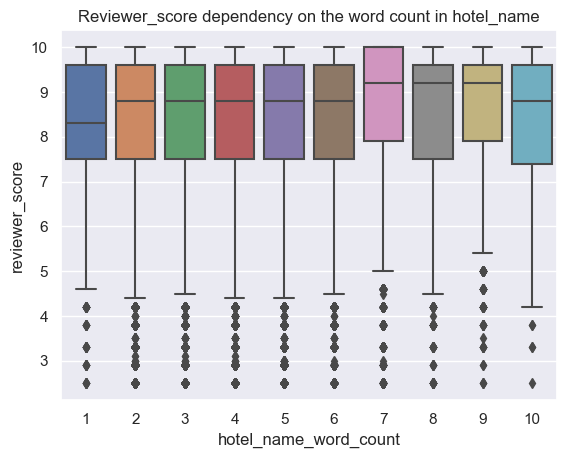

In [22]:
# Создадим признак с количеством слов в имени
data['hotel_name_word_count'] = data['hotel_name']\
    .apply(lambda x: len(x.split(' ')))

sns.boxplot(x='hotel_name_word_count', y = 'reviewer_score', 
    data=data.query('sample==1'))
plt.title('Reviewer_score dependency on the word count in hotel_name');

count    515738.000000
mean          3.903019
std           1.409375
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max          10.000000
Name: hotel_name_word_count, dtype: float64

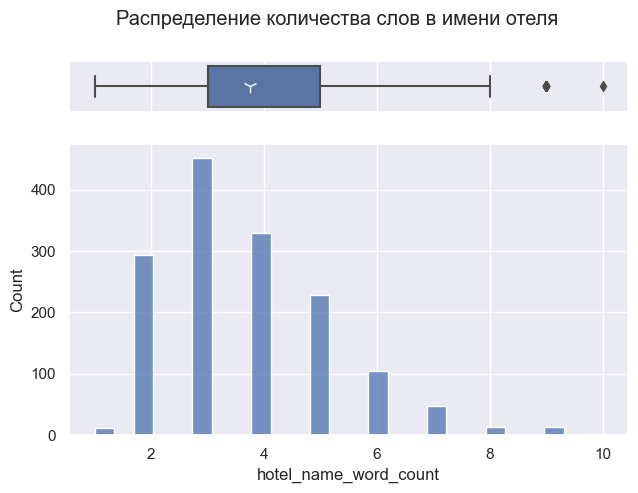

In [23]:
display(data['hotel_name_word_count'].describe())

hotel_name_word_count = data.groupby(by=['hotel_name', 'hotel_address'])\
    ['hotel_name_word_count'].median().reset_index()
box_hist_plot(hotel_name_word_count, 'hotel_name_word_count',\
    'Распределение количества слов в имени отеля')

При необходимости, можно было бы в дальнейшем 
проверить статистическую значимость результата, что отели с размером имён в 
7-9 слов имеют несколько выше медианный рейтинг, 
поэтому пока оставим этот показатель

**Дополним имя отеля Hotel Regina городом**

Сделано для удобства последующего предварительного анализа колонок

In [24]:
data['hotel_name'] = data.apply(lambda x: x['hotel_name']+ ' [' +\
    x['hotel_city'] + ']' if x['hotel_name']=='Hotel Regina'\
    else x['hotel_name'], axis=1)

data[data['hotel_name'].str.contains('Hotel Regina')]['hotel_name'].unique()

array(['Hotel Regina [Paris]', 'Hotel Regina [Barcelona]',
       'Hotel Regina [Vienna]', 'Hotel Regina [Milan]',
       'Hotel Regina Op ra Grands Boulevards'], dtype=object)

#### **additional_number_of_scoring**

Согласно представленному выше описанию получается, что это общее количество оценок без отзывов, которое выставлено отелю. Значит у разных отзывов одного отеля должны быть одинаковые значения. Проверим это.

count    515738.000000
mean        498.081836
std         500.538467
min           1.000000
25%         169.000000
50%         341.000000
75%         660.000000
max        2682.000000
Name: additional_number_of_scoring, dtype: float64

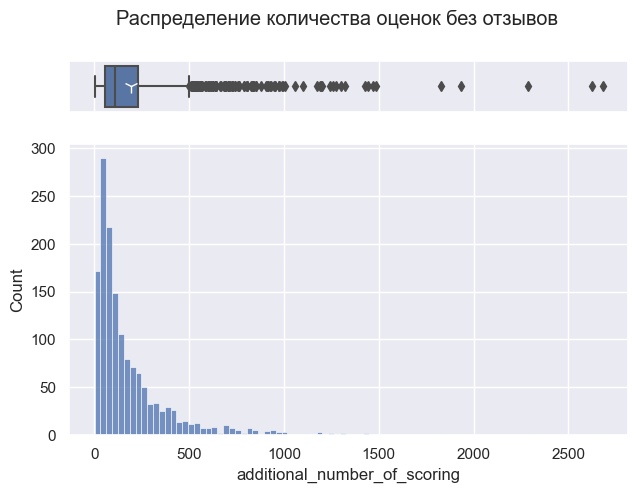

In [25]:
display(data['additional_number_of_scoring'].describe())

addit_n_scoring = data.groupby(by=['hotel_name', 'hotel_address'])\
    ['additional_number_of_scoring'].median().reset_index()
box_hist_plot(addit_n_scoring, 'additional_number_of_scoring',\
    'Распределение количества оценок без отзывов')

In [26]:
grouped_by_name = data.groupby(by='hotel_name')
scoring_number_difference = grouped_by_name['additional_number_of_scoring']\
    .max() - grouped_by_name['additional_number_of_scoring'].min()
scoring_number_difference.sort_values(ascending=False)

hotel_name
11 Cadogan Gardens                       0
Mercure Paris Gare De Lyon TGV           0
Mercure Paris Opera Louvre               0
Mercure Paris Opera Grands Boulevards    0
Mercure Paris Opera Garnier              0
                                        ..
Hotel Balzac                             0
Hotel Balmoral                           0
Hotel Balmes                             0
Hotel Bagu s                             0
pentahotel Vienna                        0
Name: additional_number_of_scoring, Length: 1494, dtype: int64

Видим, что разницы в количестве отзывов нет, 
все имена отелей уникальны и содержат одно и тоже количество отзывов

**Note:**
- Распределение похоже на логнормальное. 
Стоит прологарифмировать и проверить на нормальность

Прологарифмируем признак

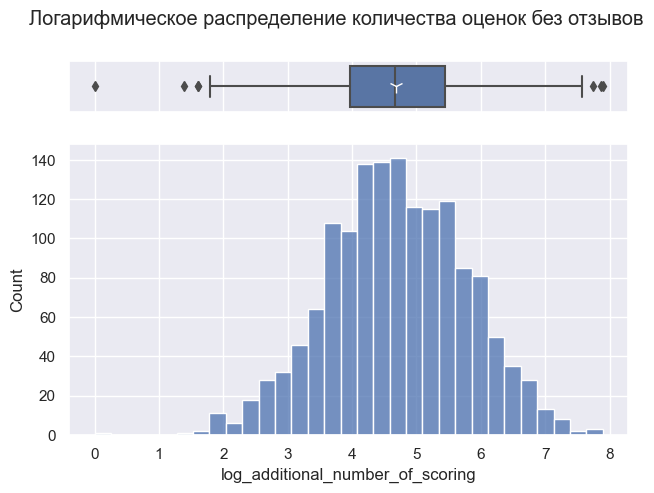

In [27]:
data['log_additional_number_of_scoring'] =\
    np.log(data['additional_number_of_scoring'])

log_addit_n_scoring = data.groupby(by=['hotel_name'])\
    ['log_additional_number_of_scoring'].median().reset_index()
box_hist_plot(log_addit_n_scoring, 'log_additional_number_of_scoring',\
    'Логарифмическое распределение количества оценок без отзывов')

#### **review_date**->datetime->month & season -> winter_review

Приведём к формату datetime

In [28]:
data['review_date'] = pd.to_datetime(data['review_date'])
data['review_date'].describe(datetime_is_numeric=True)

count                           515738
mean     2016-08-13 13:23:37.096277248
min                2015-08-04 00:00:00
25%                2016-02-23 00:00:00
50%                2016-08-15 00:00:00
75%                2017-02-09 00:00:00
max                2017-08-03 00:00:00
Name: review_date, dtype: object

Таким образом, перед нами выгрузка отзывов за 2 года с 4 августа 2015 года по 3 августа 2017 года.

**Note:**
- В дальнейшем из даты можно извлечь сезонность

**Извлечём из даты сезонность**

In [29]:
def get_season(month):
    if month in [3,4,5]:
        return 'spring'
    if month in [6,7,8]:
        return 'summer'
    if month in [9,10,11]:
        return 'autumn'
    if month in [12,1,2]:
        return 'winter'
    
data['review_month'] = data['review_date'].dt.month
data['review_season'] = data['review_month'].apply(get_season)
data['review_season'].value_counts()

summer    142886
spring    130483
autumn    122241
winter    120128
Name: review_season, dtype: int64

count    515738.000000
mean          6.486660
std           3.351779
min           1.000000
25%           4.000000
50%           7.000000
75%           9.000000
max          12.000000
Name: review_month, dtype: float64

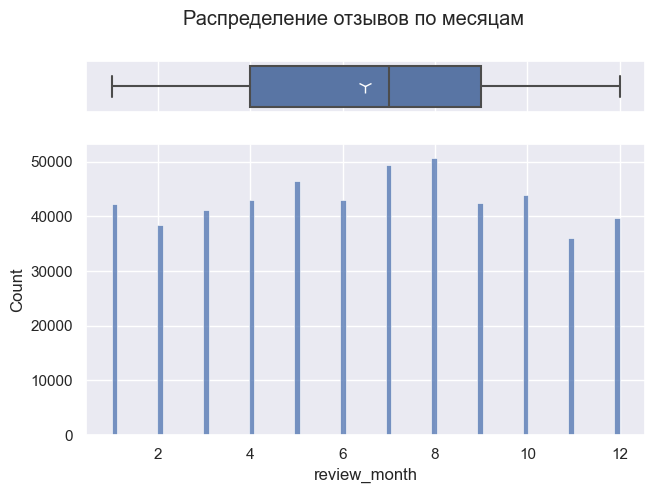

In [30]:
display(data['review_month'].describe())

box_hist_plot(data, 'review_month',\
    'Распределение отзывов по месяцам')

Оценим наличие влияния месяца и сезонности на отзыв

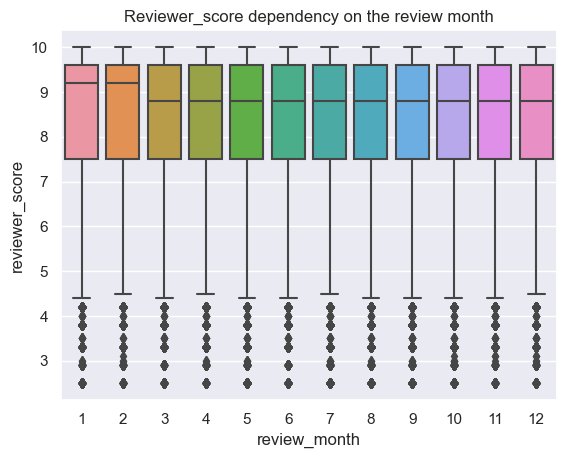

In [31]:
sns.boxplot(x='review_month', y = 'reviewer_score', 
    data=data.query('sample==1'))
plt.title('Reviewer_score dependency on the review month');

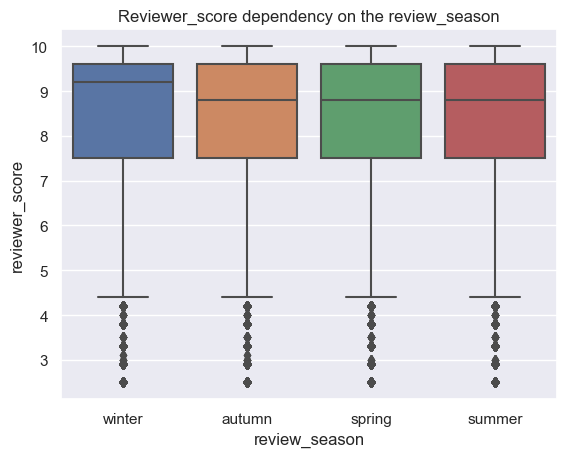

In [32]:
sns.boxplot(x='review_season', y = 'reviewer_score', 
    data=data.query('sample==1'))
plt.title('Reviewer_score dependency on the review_season');

Имеется небольшое расхождение по месяцам и сезонам: медианный рейтинг зимой 
(Январь-Февраль) выше, чем в остальные месяцы. Введём бинарный рейтинг

In [33]:
data['winter_review'] = data['review_month'].apply(lambda x: 1 if x in [1,2]
                                                   else 0)

#### **average_score**

Данный признак представляет собой среднюю оценку отеля за последний год. Проанализируем его

count    515738.000000
mean          8.397487
std           0.548048
min           5.200000
25%           8.100000
50%           8.400000
75%           8.800000
max           9.800000
Name: average_score, dtype: float64

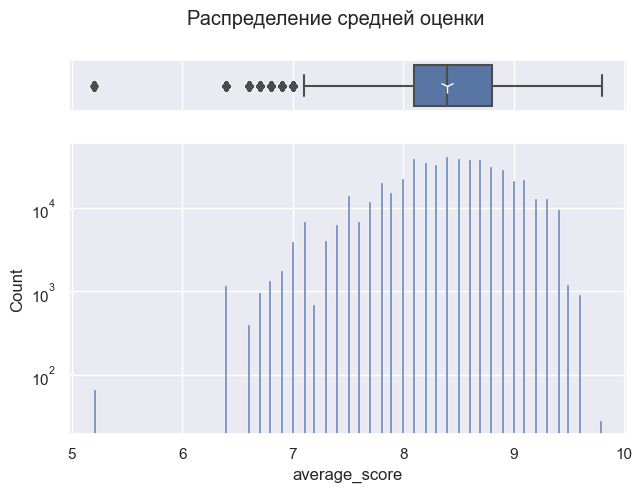

In [34]:
average_score_plot = box_hist_plot(data, 'average_score',\
    'Распределение средней оценки', hist_yscale='log')
display(data['average_score'].describe())
average_score_plot

Наблюдаем левосторонние гипотетические выбросы, а также отели с очень высокой оценкой

Введём группировку по отелям

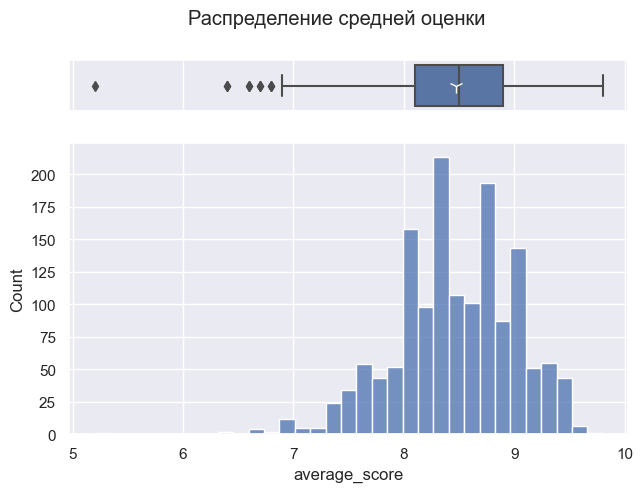

In [35]:
average_score = data.groupby(by=['hotel_name'])\
    ['average_score'].median().reset_index()
box_hist_plot(average_score, 'average_score',\
    'Распределение средней оценки')

**Note**:
- Имеет смысл ввести порядковый категориальный признак, чтобы отличать плохие, хорошие и очень хорошие отели
- Стоит проверить на нормальность

Воспользуемся [шкалой оценок отелей](https://krass56-ru.turbopages.org/krass56.ru/s/scale_of_rating_of_hotel_which_rating_of_hotel_to_choose_for_staying.html)

In [36]:
normal_rating = 7.0
good_rating = 8.0
excelent_rating = 9.0

def get_score_rating(average_score):
    # not good
    if average_score < normal_rating:
        return 0
    # normal
    if average_score >= normal_rating and average_score < good_rating:
        return 1
    # good
    if average_score >= good_rating and average_score < excelent_rating:
        return 2
    # excellent
    if average_score >= excelent_rating:
        return 3
    
data['hotel_rating'] = data['average_score'].apply(get_score_rating)
data['hotel_rating'].value_counts()

2    341578
1     88982
3     79513
0      5665
Name: hotel_rating, dtype: int64

Оценим визуально взаимосвязь средней оценки и медианной оценки в отзыве

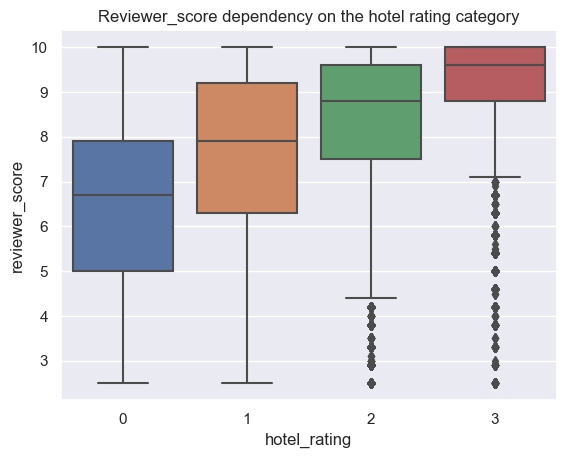

In [37]:
sns.boxplot(x='hotel_rating', y = 'reviewer_score', 
    data=data.query('sample==1'))
plt.title('Reviewer_score dependency on the hotel rating category');

**Note**: имеется заметная взаимосвязь с рейтингом отеля, что ожидаемо

#### **reviewer_nationality** -> reviewer_country_group and is_international

In [38]:
data['reviewer_nationality'] = data['reviewer_nationality'].str.strip()
print('Представленные в датасете национальности:')
display(data['reviewer_nationality'].value_counts().head(60))

Представленные в датасете национальности:


United Kingdom              245246
United States of America     35437
Australia                    21686
Ireland                      14827
United Arab Emirates         10235
Saudi Arabia                  8951
Netherlands                   8772
Switzerland                   8678
Germany                       7941
Canada                        7894
France                        7296
Israel                        6610
Italy                         6114
Belgium                       6031
Turkey                        5444
Kuwait                        4920
Spain                         4737
Romania                       4552
Russia                        3900
South Africa                  3821
India                         3437
Greece                        3406
China                         3400
Sweden                        3368
New Zealand                   3237
Singapore                     3091
Hong Kong                     3013
Poland                        2891
Qatar               

**Note**:
- Возможно, имеет смысл сопоставить национальность рецензента и страну, где находится отель. И выделить признак международного путешествия рецензента. Можно проверить гипотезу влияния типа поездки - международная или национальная на оставляемый рейтинг.
- Также можно уменьшить количество рассматриваемых национальностей, введя категорию 'other'
- Скрытые пропуски не обнаружены

**Введём признак международности поездки**

In [39]:
data['is_international'] = data.apply(lambda row:\
    1 if row['reviewer_nationality'] != row['hotel_country'] else 0, axis = 1)
data['is_international'].value_counts(normalize=True)

1    0.654082
0    0.345918
Name: is_international, dtype: float64

Проверим влияние международности поездки на оценку

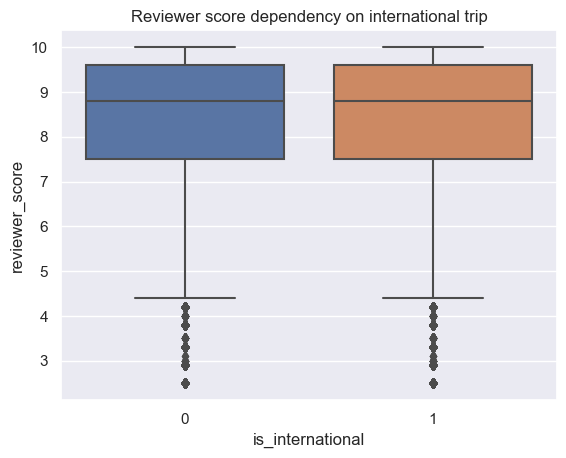

In [40]:
sns.boxplot(x='is_international', y='reviewer_score', 
    data=data.query('sample==1'))
plt.title('Reviewer score dependency on international trip');

Таким образом, медианные значения не отличаются. 
Нижний квартиль в случае поездки внутри страны несколько выше, 
чем при международной

Введём группы стран и оценим влияние принадлежности той или иной группе.
В дальнейшем разбивку можно было бы провести на более мелкие группы.

Все представленные отели - Европейские

In [41]:
# Введём группы для стран с количеством отзывов рецензентов оттуда больше 1000
country_groups = {
    'western_europe': [
        'Netherlands', 'Switzerland', 'Germany',
        'France', 'Belgium','Austria', 'Luxembourg'],
    'central_eastern_europe': [
        'Russia', 'Poland', 'Ukraine', 'Bulgaria', 'Hungary', 
        'Czech Republic', 'Romania', 'Croatia', 'Serbia'
        ],
    'northern_europe': [
        'United Kingdom', 'Ireland', 'Norway', 'Sweden', 'Finland', 
        'Denmark'],
    'southern_europe': [
        'Italy', 'Spain', 'Malta', 'Portugal', 'Cyprus', 'Greece'
        ],
    'america':
        ['United States of America', 'Canada', 'Brazil'],
    'middle_east_africa': [
        'United Arab Emirates', 'Saudi Arabia', 'Israel', 'Turkey', 'Kuwait',
        'Qatar', 'Egypt', 'Lebanon', 'Bahrain', 'Oman', 'Iran', 'South Africa'
        ],
    'asia_oceania': [
        'India', 'China', 'Singapore', 'Hong Kong', 'Malaysia', 'Thailand',
        'Indonesia', 'Japan', 'South Korea', 'Philippines', 'Australia',
        'New Zealand']
}

# Введём функцию для сортировки по группам стран
def get_country_group(country):
    for key in country_groups:
        if country in country_groups[key]:
            return key
    return 'ungrouped'

data['reviewer_country_group'] = data['reviewer_nationality']\
    .apply(get_country_group)
data['reviewer_country_group'].value_counts(normalize=True)

northern_europe           0.522314
middle_east_africa        0.099661
asia_oceania              0.090366
america                   0.087634
western_europe            0.082385
ungrouped                 0.040313
central_eastern_europe    0.040173
southern_europe           0.037155
Name: reviewer_country_group, dtype: float64

Проанализируем влияние группы стран на рейтинг

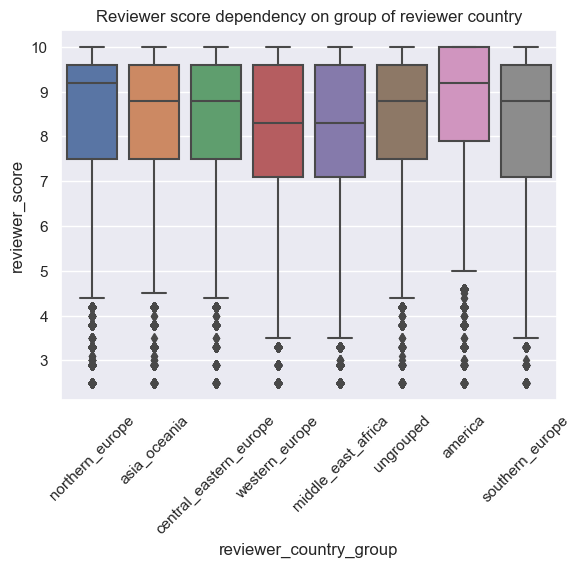

In [42]:
sns.boxplot(x='reviewer_country_group', y='reviewer_score', 
    data=data.query('sample==1'))
plt.xticks(rotation=45)
plt.title('Reviewer score dependency on group of reviewer country');

Влияние имеет место, оставим группы стран для последующего анализа.

#### **tags** -> **splitted_tags** -> tags classification

Извлечём теги и сохраним их в множество, тем самым получим уникальные теги.

In [43]:
# Переведём в нижний регистр
data['tags'] = data['tags'].str.lower()

# Извлечём сырые теги из соответствующей колонки 
# и сохраним в виде списка
data['splitted_tags'] = data['tags'].str.findall(r"'[\w\s]+'")

# Преобразуем списки, удалив одинарные кавычки и внешние пробелы
data['splitted_tags'] = data['splitted_tags'].\
    apply(lambda x: [y[1:-1].strip() for y in x])
    
# Создадим множество уникальных тегов
unique_tags = set()
# Функия извлечения тегов в множество
def get_tags(tags):
    unique_tags.update(tags)
    return True
data['splitted_tags'].apply(get_tags)
print('Количество уникальных тегов:', len(unique_tags))

Количество уникальных тегов: 2421


In [44]:
print('Минимальное количество тегов в отзыве:', data['splitted_tags']\
    .apply(len).min())
print('Максимальное количество тегов в отзыве:', data['splitted_tags']\
    .apply(len).max())

Минимальное количество тегов в отзыве: 1
Максимальное количество тегов в отзыве: 6


Пропуски тегов отсутствуют

Оценим популярность тегов

In [45]:
# Создадим пустой список, который будем заполнять тегами 
# из датафрейма 
tags_list = []
def extend_tags(tags):
    tags_list.extend(tags)
data['splitted_tags'].apply(extend_tags)

# Посчитаем количество применений тегов
# и представим в виде Series
cnt = Counter(tags_list)
tag_cnt = pd.Series(dict(cnt))

# Выведем отсортированный Series
tag_cnt.sort_values(ascending=False).head(60)

leisure trip                           417778
submitted from a mobile device         307640
couple                                 252294
stayed 1 night                         193645
stayed 2 nights                        133937
solo traveler                          108545
stayed 3 nights                         95821
business trip                           82939
group                                   65392
family with young children              61015
stayed 4 nights                         47817
double room                             35207
standard double room                    32248
superior double room                    31393
family with older children              26349
deluxe double room                      24823
double or twin room                     22393
stayed 5 nights                         20845
standard double or twin room            17483
classic double room                     16989
superior double or twin room            13570
2 rooms                           

**Note**:
- В качестве отдельного признака можно создать количество присвоенных тегов
- Имеет смысл выделить конкретные популярные теги
- Из тегов можно выделить такую полезную информацию, как:
    - отправлен ли отзыв с мобильного устройства;
    - количество ночей, проведённых в гостинице;
    - тип номера;
    - тип путешествия;
    - состав посетителей;

**Количество присвоенных тегов**

In [46]:
data['tags_count'] = data['splitted_tags'].apply(len)
data['tags_count'].describe()

count    515738.000000
mean          4.569359
std           0.520187
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           6.000000
Name: tags_count, dtype: float64

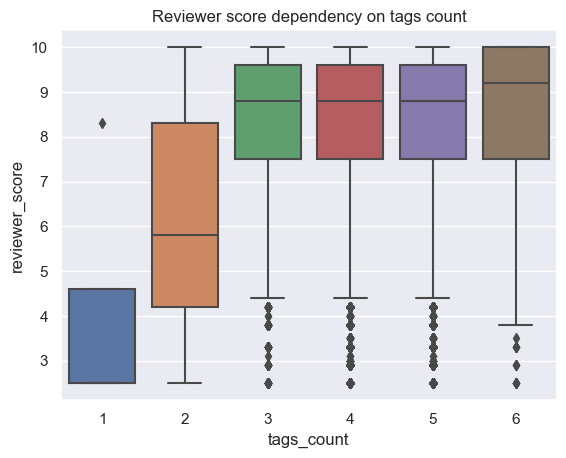

In [47]:
sns.boxplot(x='tags_count', y='reviewer_score', 
    data=data.query('sample==1'))
plt.title('Reviewer score dependency on tags count');

Влияние имеется, но для малочисленных групп в 1-2 тега. Пока оставим признак.

Введём trip_type: Leisure trip, Business trip

Введём is_mobile_review: Submitted from a mobile device

Введём stayed_nights: Stayed X night(s)

Введём trip_group: Solo traveler, Couple, Family with young children,
Family with older children, Group

Введём room_beds: Single, Twin, Double, Triple, Queen, King

Введём room_type: Small, (Basic, Standard, Club, Classic, Comfort, Guest), 
Superior, Junior Suite, Deluxe, Executive, 2 rooms

**trip_type**

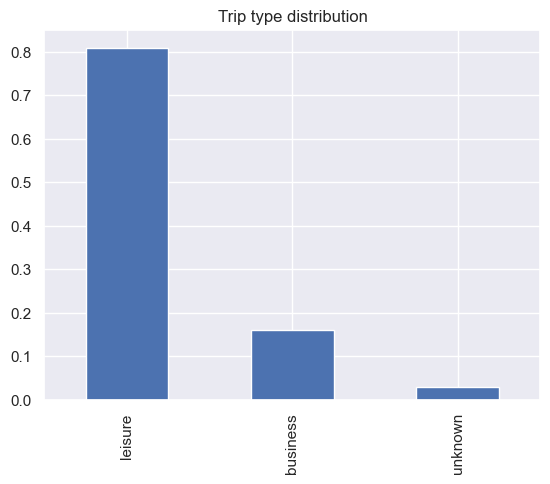

In [48]:
# Trip type
def get_trip_type(tags):
    if 'leisure trip' in tags:
        return 'leisure'
    if 'business trip' in tags:
        return 'business'
    return 'unknown'

data['trip_type'] = data['tags'].apply(get_trip_type)
data['trip_type'].value_counts(normalize=True).plot.bar()
plt.title('Trip type distribution');

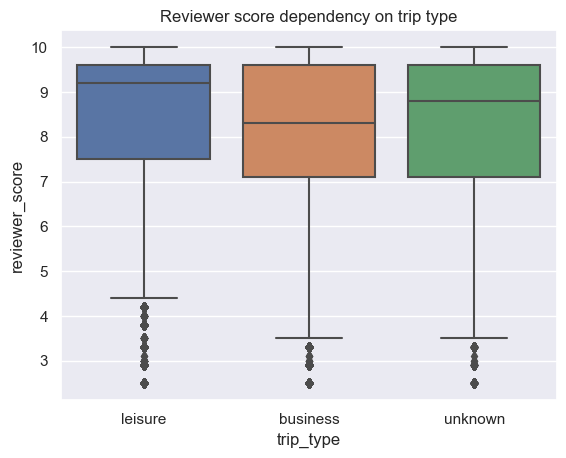

In [49]:
sns.boxplot(x='trip_type', y='reviewer_score', data=data.query('sample==1'))
plt.title('Reviewer score dependency on trip type');

Рейтинг выше в случае туристической поездки. 
Можно предположить, что общие впечатления от поездки выше, 
поэтому и рейтинг выставляют выше. Скорее всего достаточно оставить leisure
как бинарный признак.

**is_mobile**

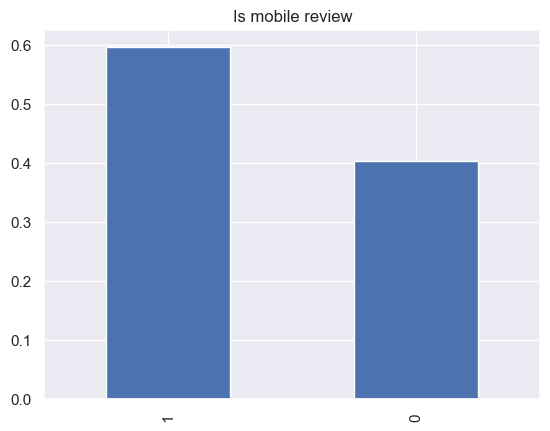

In [50]:
data['is_mobile'] = data['tags'].str.contains('submitted from a mobile device')
data['is_mobile'] = data['is_mobile'].astype('int')
data['is_mobile'].value_counts(normalize=True).plot.bar()
plt.title('Is mobile review');

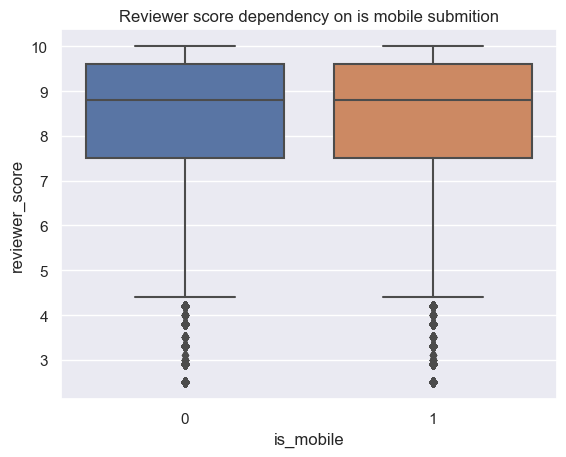

In [51]:
sns.boxplot(x='is_mobile', y='reviewer_score', data=data.query('sample==1'))
plt.title('Reviewer score dependency on is mobile submition');

Скорее всего, нет разницы в том, отправлено ли с мобильного устройства

**night_count**

In [52]:
# Количество проведённых ночей
data['night_count'] = data['tags'].str.extract(r'stayed (\d+) night')\
    .astype('float')
display(data['night_count'].describe())
print(f'Количество пропусков: {sum(data["night_count"].isna())}')

count    515546.000000
mean          2.362257
std           1.647099
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          31.000000
Name: night_count, dtype: float64

Количество пропусков: 192


Заполним пропуски медианным значением

In [53]:
data['night_count'] = data['night_count'].fillna(data['night_count'].median())
if data['night_count'].notna().all():
    print('Пропуски заполнены')

# Переведём в тип int
data['night_count'] = data['night_count'].astype('int')

Пропуски заполнены


Проанализируем распределение и влияние на оценку в отзыве

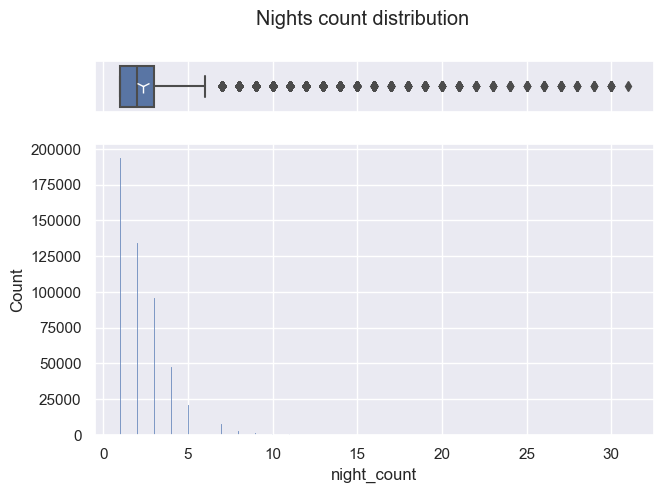

In [54]:
box_hist_plot(data, x='night_count', title='Nights count distribution')

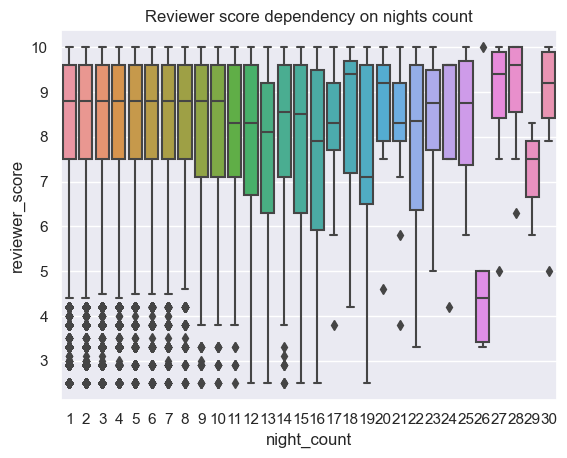

In [55]:
sns.boxplot(x='night_count', y='reviewer_score', data=data.query('sample==1'))
plt.title('Reviewer score dependency on nights count');

Пусть 5 и более ночей будут соответствовать 5

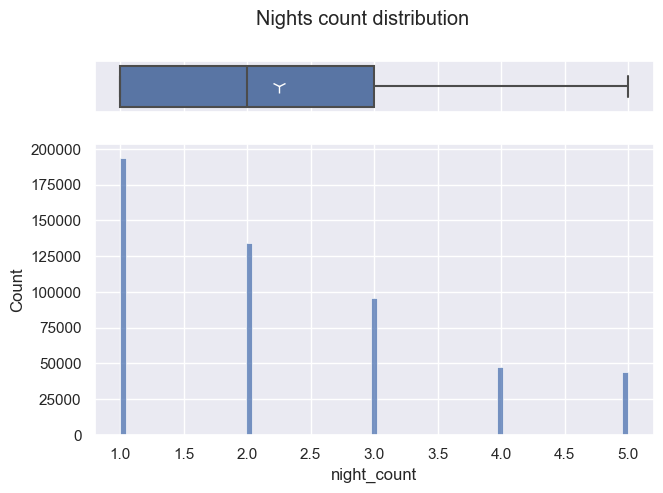

In [56]:
data['night_count'] = data['night_count'].apply(lambda x: 5 if x >=5 else x)
box_hist_plot(data, x='night_count', title='Nights count distribution')

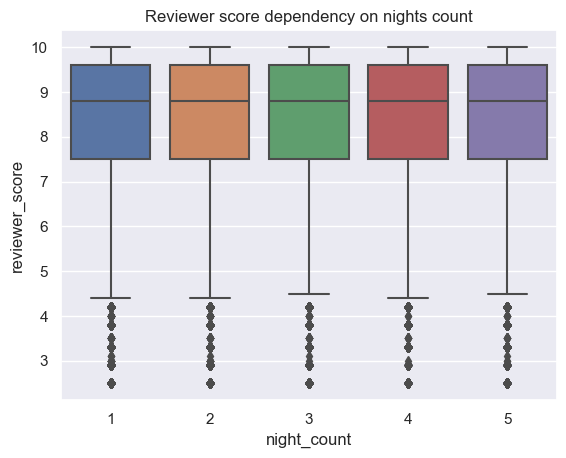

In [57]:
sns.boxplot(x='night_count', y='reviewer_score', data=data.query('sample==1'))
plt.title('Reviewer score dependency on nights count');

Вероятнее всего, количество проведённых ночей в среднем не влияет на рейтинг

**Trip group**

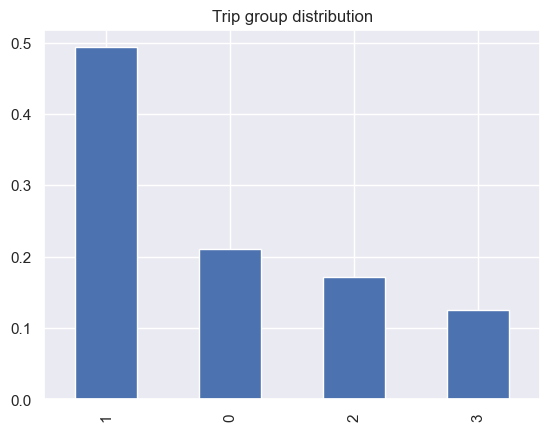

In [58]:
def get_trip_group(tags):
    if 'solo traveler' in tags:
        return 0
    if 'couple' in tags:
        return 1
    if 'family' in tags:
        return 2
    if 'group' in tags:
        return 3
    # Чаще всего путешествуют парой
    return 1

data['trip_group'] = data['tags'].apply(get_trip_group)
data['trip_group'].value_counts(normalize=True).plot.bar()
plt.title('Trip group distribution');

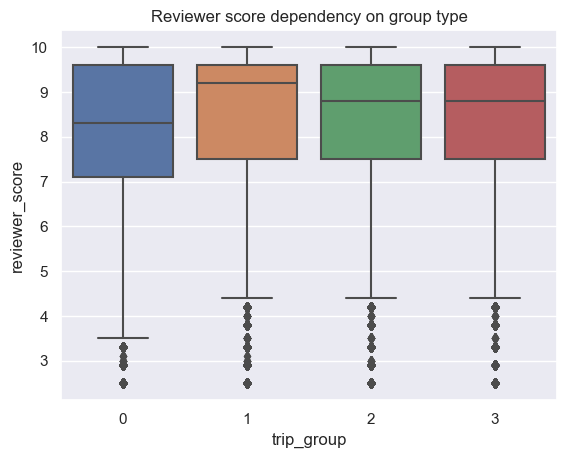

In [59]:
sns.boxplot(x='trip_group', y='reviewer_score', data=data.query('sample==1'))
plt.title('Reviewer score dependency on group type');

В одиночку путешествующие ставят ниже рейтинг, а пары - выше. 
Семьи и группы имеют схожее распределение

**room_beds**

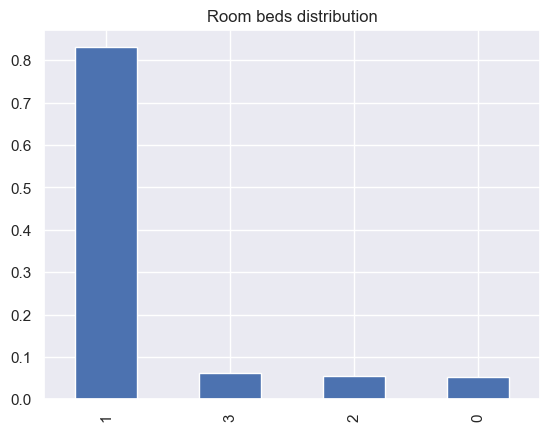

In [60]:
def get_room_beds(tags):
    if 'single' in tags:
        return 0
    if 'twin' in tags or 'double' in tags:
        return 1
    # Анализ распределений показал, что triple мало чем отличается
    if 'triple' in tags:
        return 1
    if 'queen' in tags:
        return 2
    if 'king' in tags:
        return 3
    # Пропуски заполняем медианным
    return 1

data['room_beds'] = data['tags'].apply(get_room_beds)
data['room_beds'].value_counts(normalize=True).plot.bar()
plt.title('Room beds distribution');

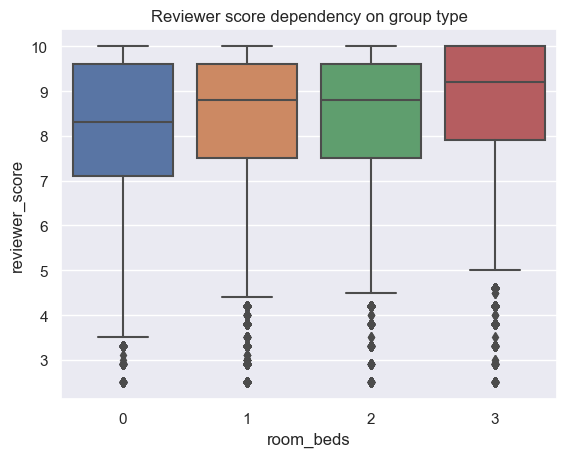

In [61]:
sns.boxplot(x='room_beds', y='reviewer_score', data=data.query('sample==1'))
plt.title('Reviewer score dependency on group type');

Чем больше размер кровати, тем рейтинг в среднем выше: 
single - ниже всего, king - больше всего

**room_type**

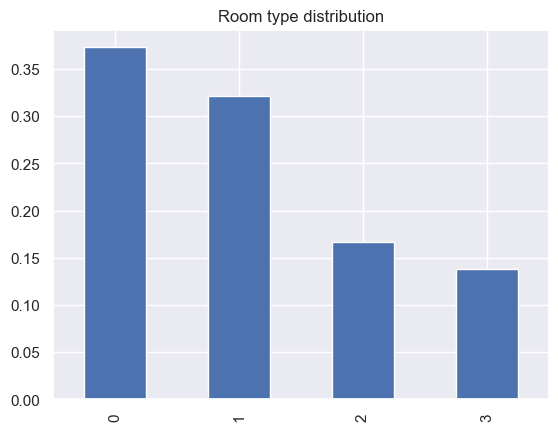

In [62]:
standard_list = ['small', 'basic', 'standard', 'club', 'classic', 
    'comfort', 'guest']
def get_room_type(tags):
    for elem in standard_list:
        if elem in tags:
            return 1
    if 'superior' in tags:
        return 2
    if 'junior suite' in tags or 'deluxe' in tags:
        return 3
    if 'executive' in tags:
        return 0
    if '2 rooms' in tags:
        return 0
    # Пропуски близки по распределению к standard
    # Присоединим к ним executive и 2 rooms, так как распределения близки
    return 0

data['room_type'] = data['tags'].apply(get_room_type)
data['room_type'].value_counts(normalize=True).plot.bar()
plt.title('Room type distribution');

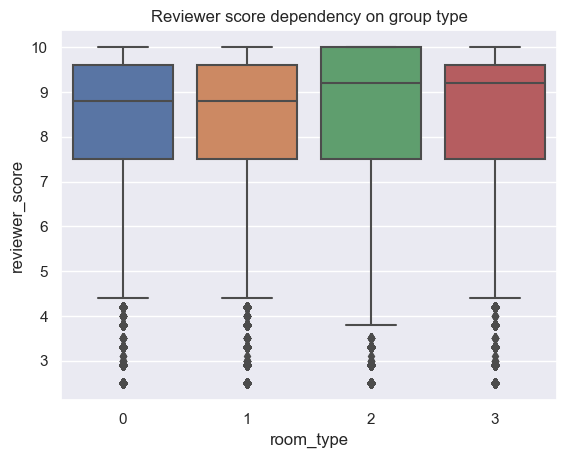

In [63]:
sns.boxplot(x='room_type', y='reviewer_score', data=data.query('sample==1'))
plt.title('Reviewer score dependency on group type');

Интересно, что executive имеет такой же рейтинг в среднем, как и standard.
Возможно из-за корреляции с buisness trip, или что ожидания выше, 
чем действительность. Та же история и с 2 rooms. Объединим с категорией 0

#### **negative_review** и **positive_review** -> many features

Удалим лишние пробелы и переведём в нижний регистр

In [64]:
data['negative_review'] = data['negative_review'].str.strip().str.lower()
data['positive_review'] = data['positive_review'].str.strip().str.lower()

In [65]:
print('Частые негативные отзывы')
data['negative_review'].value_counts().sort_values(ascending=False).head(60)

Частые негативные отзывы


no negative                        127890
nothing                             21185
n a                                  1815
none                                 1501
                                      849
nothing really                        656
small room                            570
all good                              545
breakfast                             545
no complaints                         523
location                              502
nothing at all                        467
everything                            420
nothing to dislike                    373
price                                 348
nil                                   332
small rooms                           307
everything was perfect                276
na                                    272
can t think of anything               250
leaving                               244
absolutely nothing                    242
everything was great                  222
expensive                         

In [66]:
print('Частые позитивные отзывы')
data['positive_review'].value_counts().sort_values(ascending=False).head(60)

Частые позитивные отзывы


no positive                        35946
location                           11945
everything                          3314
nothing                             1731
great location                      1687
the location                        1606
good location                       1496
breakfast                            795
friendly staff                       733
excellent location                   639
staff                                553
location and staff                   452
location staff                       432
location location location           345
location was great                   328
good breakfast                       316
everything was perfect               316
location was good                    312
comfy bed                            303
perfect location                     287
the staff                            281
location is great                    280
location is good                     256
all                                  250
clean           

**Note**:
- Мы видим, что в отзывах большое количество слов, типа "No Positive/Negative", "Nothing", "Everything", "NA". Их можно представить в виде булевых признаков, типа "no_positive", "no_negative", "abs_positive", "abs_negative"
- Из отзывов можно извлечь, чем клиент был доволен/недоволен, например: "location", "staff" и проверить гипотезу влияния этих категорий на оценку

**review_type**

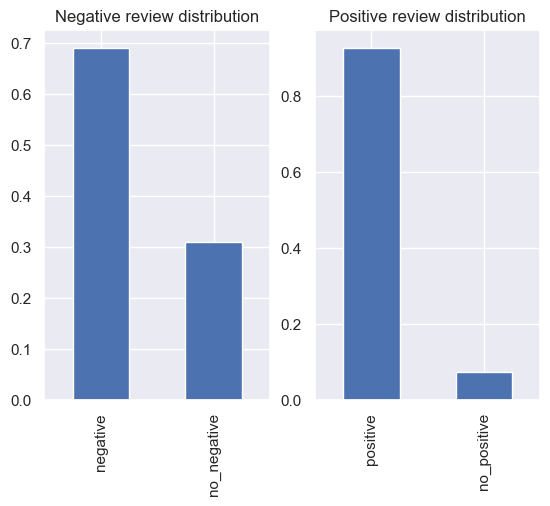

In [67]:
# Списки можно дополнять
no_negative_lt = [
    '', 'no negative', 'nothing', 'n a', 'none', 
    'nothing really', 'all good', 'no complaints', 'nothing at all',
    'nothing to dislike', 'nil', 'everything was perfect', 'na', 
    'can t think of anything', 'absolutely nothing', 'everything was great',
    'nothing to complain about', 'no', 'nothing not to like', 
    'everything was good', 'i liked everything', 
    'liked everything', 'nothing it was perfect',
    'nothing everything was perfect', 'non', 'having to leave', 'leaving',
    'nothing in particular', 'everything was fine',
    'nothing everything was great', 'all was good', 
    ]

abs_negative_lt = ['everything']

no_positive_lt = ['', 'no positive', 'nothing']

abs_positive_lt = [
    'everything', 'all', 'every thing', 'everything was great', 'all good'
    ]

# Negative review analysis
def get_negative_review_type(negative_review):
    if negative_review in no_negative_lt:
        return 'no_negative'
    # Очень мало таких, поэтому отнесём к negative
    if negative_review in abs_negative_lt:
        return 'negative'
    return 'negative'

# Positive review analysis
def get_positive_review_type(positive_review):
    if positive_review in no_positive_lt:
        return 'no_positive'
    # Очень мало таких, поэтому отнесём к positive
    if positive_review in abs_positive_lt:
        return 'positive'
    return 'positive'

data['negative_review_type'] = data['negative_review']\
    .apply(get_negative_review_type)
data['positive_review_type'] = data['positive_review']\
    .apply(get_positive_review_type)
    
fig, (neg, pos) = plt.subplots(1,2)
data['negative_review_type'].value_counts(normalize=True).plot.bar(ax=neg)
neg.set_title('Negative review distribution');

data['positive_review_type'].value_counts(normalize=True).plot.bar(ax=pos)
pos.set_title('Positive review distribution');

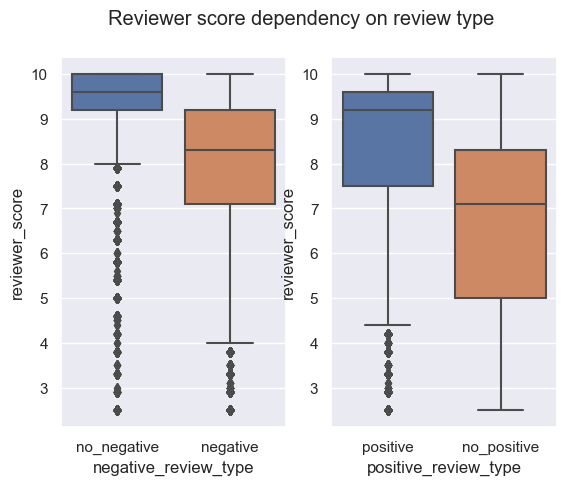

In [68]:
fig, (neg, pos) = plt.subplots(1,2)
sns.boxplot(x='negative_review_type', y='reviewer_score',
    data=data.query('sample==1'), ax=neg)
# neg.set_title('Reviewer score dependency on negative review type')

sns.boxplot(x='positive_review_type', y='reviewer_score',
    data=data.query('sample==1'), ax=pos)
# pos.set_title('Reviewer score dependency on positive review type');

fig.suptitle('Reviewer score dependency on review type');

Заметно существенное расхождение по типам комментариев

**what_positive/negative**

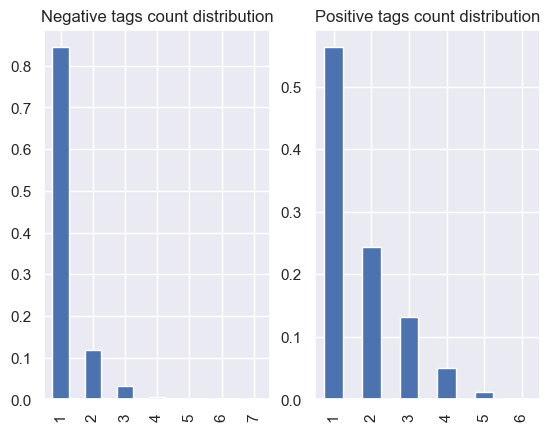

In [69]:
positive_tags = ['location', 'breakfast', 'staff', 'bed',\
    ['clean', 'cleanliness'], 'room']
def get_what_positive(review):
    # Подготовим множество тэгов из отзыва
    current_tags = set()
    # Перебираем тэги
    for tag in positive_tags:
        # Если тэг представляет собой вложенный список, 
        # просматривать по элементам
        if isinstance(tag, list):
            for sub_tag in tag:
                # Если тэг обнаружен, добавить основной (первый) тэг списка 
                if sub_tag in review:
                    current_tags.add('pos_'+tag[0])
        # Если тэг обнаружен, добавить его
        elif tag in review:
            current_tags.add('pos_'+tag)
    # Если тэги не обнаружены
    if not len(current_tags):
        current_tags.add('pos_other')
        
    return list(current_tags)

negative_tags = ['location', 'room', ['price', 'expensive'], 'breakfast', 
    'staff', 'wifi', 'pillow', 'bed']
def get_what_negative(review):
    # Подготовим множество тэгов из отзыва
    current_tags = set()
    # Перебираем тэги
    for tag in negative_tags:
        # Если тэг представляет собой вложенный список, 
        # просматривать по элементам
        if isinstance(tag, list):
            for sub_tag in tag:
                # Если тэг обнаружен, добавить основной (первый) тэг списка 
                if sub_tag in review:
                    current_tags.add('neg_'+tag[0])
        # Если тэг обнаружен, добавить его
        elif tag in review:
            current_tags.add('neg_'+tag)
    # Если тэги не обнаружены
    if not len(current_tags):
        current_tags.add('neg_other')
        
    return list(current_tags)

# Get tags from reviews
data['what_positive'] = data['positive_review'].apply(get_what_positive)
data['what_negative'] = data['negative_review'].apply(get_what_negative)

# Get tags from review count
data['pos_tag_count'] = data['what_positive'].apply(len)
data['neg_tag_count'] = data['what_negative'].apply(len)

fig, (neg, pos) = plt.subplots(1,2)
data['neg_tag_count'].value_counts(normalize=True).plot.bar(ax=neg)
neg.set_title('Negative tags count distribution');

data['pos_tag_count'].value_counts(normalize=True).plot.bar(ax=pos)
pos.set_title('Positive tags count distribution');

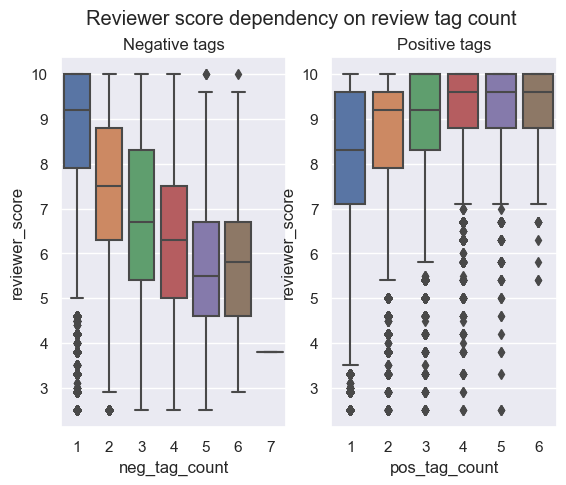

In [70]:
fig, (neg, pos) = plt.subplots(1,2)
sns.boxplot(x='neg_tag_count', y='reviewer_score',
    data=data.query('sample==1'), ax=neg)
neg.set_title('Negative tags');

sns.boxplot(x='pos_tag_count', y='reviewer_score',
    data=data.query('sample==1'), ax=pos)
pos.set_title('Positive tags');

fig.suptitle('Reviewer score dependency on review tag count');

Видно, что с увеличением количества фактических категорий в отзыве 
меняется и оценка в отзыве

Посмотрим на количество повторений тэгов в отзывах

In [71]:
# Создадим пустой список, который будем заполнять тегами 
# из датафрейма 
pos_tags_list = []
def extend_tags(tags):
    pos_tags_list.extend(tags)
data['what_positive'].apply(extend_tags)

# Посчитаем количество применений тегов
# и представим в виде Series
cnt = Counter(pos_tags_list)
pos_tag_cnt = pd.Series(dict(cnt))

# Создадим пустой список, который будем заполнять тегами 
# из датафрейма 
neg_tags_list = []
def extend_tags(tags):
    neg_tags_list.extend(tags)
data['what_negative'].apply(extend_tags)

# Посчитаем количество применений тегов
# и представим в виде Series
cnt = Counter(neg_tags_list)
neg_tag_cnt = pd.Series(dict(cnt))

# Выведем отсортированный Series
print('Negative')
display(neg_tag_cnt.sort_values(ascending=False).head(10))

print('Positive')
display(pos_tag_cnt.sort_values(ascending=False).head(10))

Negative


neg_other        274718
neg_room         158366
neg_breakfast     50106
neg_bed           37147
neg_price         36143
neg_staff         34925
neg_wifi          11588
neg_location      10941
neg_pillow         6057
dtype: int64

Positive


pos_location     189531
pos_staff        189481
pos_room         162500
pos_other        114744
pos_breakfast     82647
pos_clean         74241
pos_bed           66940
dtype: int64

Разобъём what_negative/positive на бинарные признаки,
отвечающие за конкретные тэги. Для этого создадим соответствующие признаки

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [73]:
neg_tag_lt = list(neg_tag_cnt.index)
pos_tag_lt = list(pos_tag_cnt.index)
for elem in neg_tag_lt:
    data[elem] = data['what_negative'].apply(lambda x: 1 if elem in x else 0)
for elem in pos_tag_lt:
    data[elem] = data['what_positive'].apply(lambda x: 1 if elem in x else 0)    

display(data[neg_tag_lt].describe())
display(data[pos_tag_lt].describe())

neg_price       neg_room     neg_pillow      neg_other  \
count  515738.000000  515738.000000  515738.000000  515738.000000   
mean        0.070080       0.307067       0.011744       0.532670   
std         0.255282       0.461278       0.107733       0.498932   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       1.000000   
75%         0.000000       1.000000       0.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

            neg_wifi        neg_bed  neg_breakfast      neg_staff  \
count  515738.000000  515738.000000  515738.000000  515738.000000   
mean        0.022469       0.072027       0.097154       0.067718   
std         0.148202       0.258533       0.296168       0.251262   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

        neg_location  
count  515738.000000  
mean        0.021214  
std         0.144098  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

pos_staff       pos_room      pos_clean  pos_breakfast  \
count  515738.000000  515738.000000  515738.000000  515738.000000   
mean        0.367398       0.315082       0.143951       0.160250   
std         0.482097       0.464549       0.351040       0.366838   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         1.000000       1.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

           pos_other   pos_location        pos_bed  
count  515738.000000  515738.000000  515738.000000  
mean        0.222485       0.367495       0.129795  
std         0.415916       0.482123       0.336078  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         0.000000       1.000000       0.000000  
max         1.000000       1.000000       1.000000

Оценку важности для целевой функции проведём ниже

**АНАЛИЗ ТОНАЛЬНОСТИ ТЕКСТА**

In [76]:
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

sent_keys = ['neg', 'neu', 'pos', 'compound']
for key in sent_keys:
    data['pos_rev_'+key] = 0
    data['neg_rev_'+key] = 0

def get_pos_sentiments(row):
    sent_pos_dict = sent_analyzer.polarity_scores(row['positive_review'])
    sent_neg_dict = sent_analyzer.polarity_scores(row['negative_review'])
    for key in sent_keys:
        row['pos_rev_' + key] = sent_pos_dict[key]
        row['neg_rev_' + key] = sent_neg_dict[key]
    return row

data = data.apply(get_pos_sentiments, axis=1)

Проанализируем ниже

#### **review_total_negative_word_counts** и **review_total_positive_word_counts** -> log()

count    515738.000000
mean         18.539450
std          29.690831
min           0.000000
25%           2.000000
50%           9.000000
75%          23.000000
max         408.000000
Name: review_total_negative_word_counts, dtype: float64

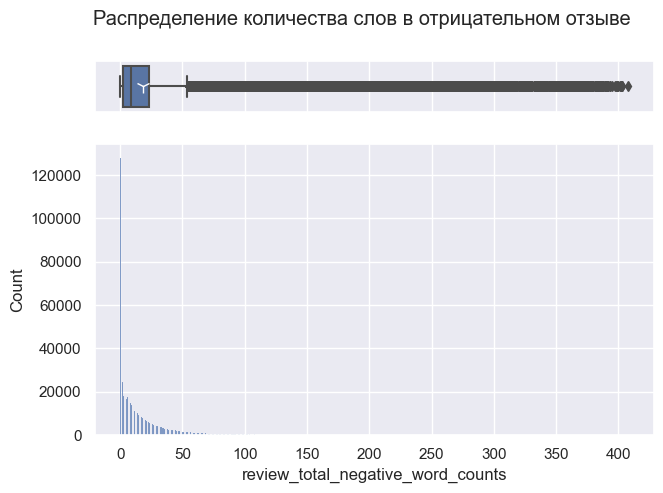

In [77]:
display(data['review_total_negative_word_counts'].describe())
box_hist_plot(data, 'review_total_negative_word_counts',\
    'Распределение количества слов в отрицательном отзыве')

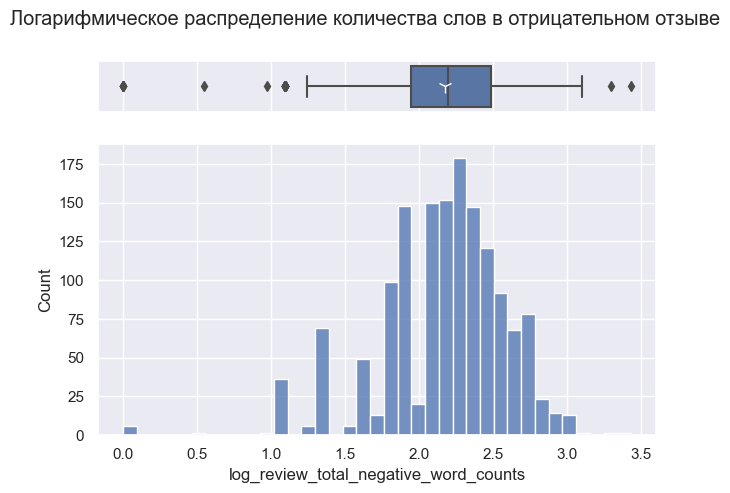

In [78]:
new_column_name = 'log_review_total_negative_word_counts'
data[new_column_name] =\
    np.log(data['review_total_negative_word_counts'] + 1)

log_review_total_negative_word_counts = data.groupby(by=['hotel_name'])\
    [new_column_name].median().reset_index()
box_hist_plot(log_review_total_negative_word_counts,
    new_column_name,
    'Логарифмическое распределение количества слов в отрицательном отзыве')

count    515738.000000
mean         17.776458
std          21.804185
min           0.000000
25%           5.000000
50%          11.000000
75%          22.000000
max         395.000000
Name: review_total_positive_word_counts, dtype: float64

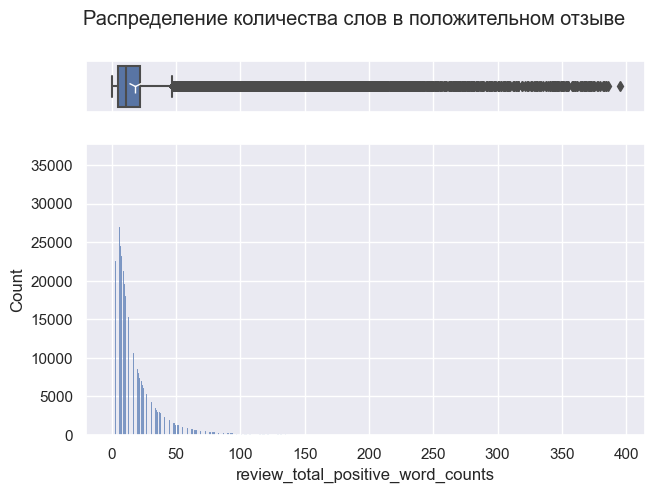

In [79]:
display(data['review_total_positive_word_counts'].describe())
box_hist_plot(data, 'review_total_positive_word_counts',\
    'Распределение количества слов в положительном отзыве')

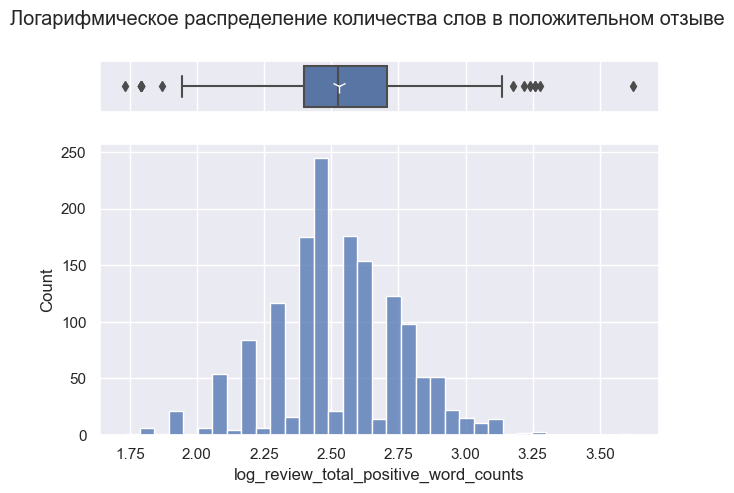

In [80]:
new_column_name = 'log_review_total_positive_word_counts'
data[new_column_name] =\
    np.log(data['review_total_positive_word_counts'] + 1)

log_review_total_positive_word_counts = data.groupby(by=['hotel_name'])\
    [new_column_name].median().reset_index()
box_hist_plot(log_review_total_positive_word_counts,
    new_column_name,
    'Логарифмическое распределение количества слов в положительном отзыве')

**Note:**
- Позитивные и негативные отзывы могут содержать до нескольких сот слов. При этом медианное количество слов порядка 10.
- Необходимо проверить, влияет ли количество слов больше 20 на оценку.
- При отсутствии слов можно отнести к категориям, выделенным выше по отзывам: no_positive, no_negative
- Возможно, имеет смысл ввести категориальный признак: короткий, средний, длинный комментарий
- Распределения похожи на логнормальные. Логарифмирование проведено. Необходимо проверить на нормальность

#### TARGET: **reviewer_score**

count    386803.000000
mean          8.396906
std           1.636090
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: reviewer_score, dtype: float64

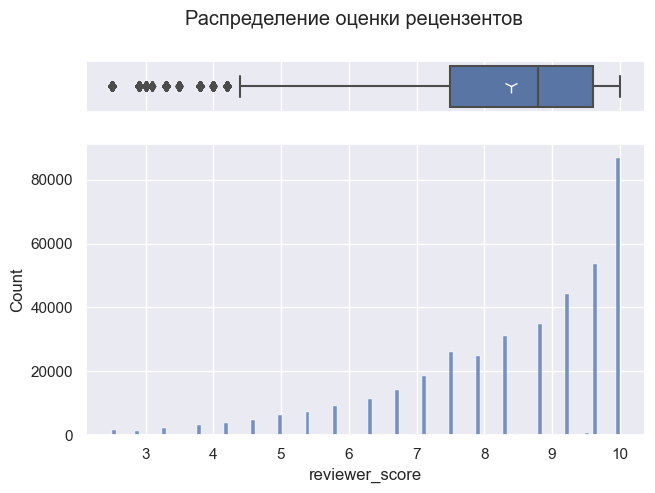

In [81]:
display(data.query('sample==1')['reviewer_score'].describe())
box_hist_plot(data.query('sample==1'), 'reviewer_score', 'Распределение оценки рецензентов')

На данном этапе не будем избавляться от аномальных значений целевого признкака.

#### **total_number_of_reviews_reviewer_has_given** -> drop

count    515738.000000
mean          7.166001
std          11.040228
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max         355.000000
Name: total_number_of_reviews_reviewer_has_given, dtype: float64

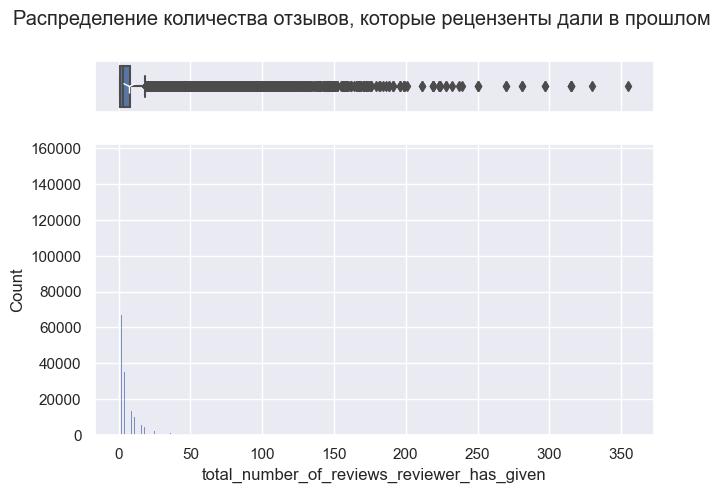

In [82]:
display(data['total_number_of_reviews_reviewer_has_given'].describe())
box_hist_plot(data, 'total_number_of_reviews_reviewer_has_given',\
    'Распределение количества отзывов, которые рецензенты дали в прошлом')

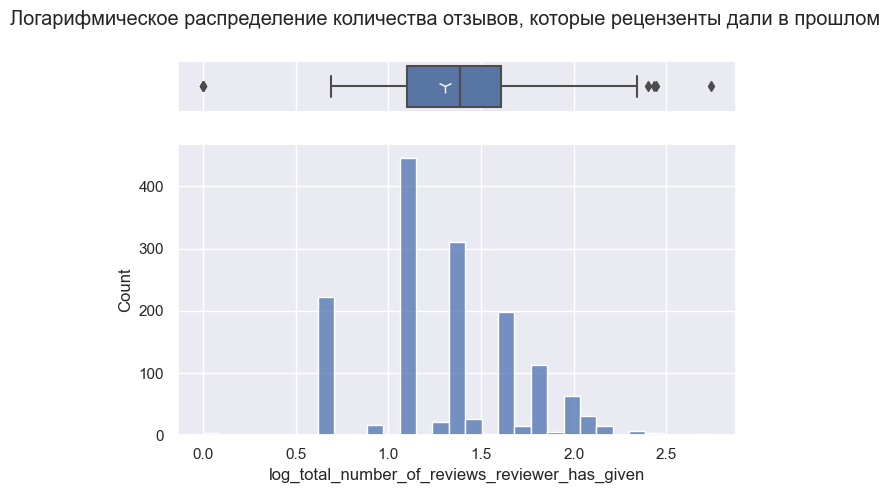

In [83]:
new_column_name = 'log_total_number_of_reviews_reviewer_has_given'
data[new_column_name] =\
    np.log(data['total_number_of_reviews_reviewer_has_given'])

log_total_number_of_reviews_reviewer_has_given = data.groupby(by=['hotel_name'])\
    [new_column_name].median().reset_index()
box_hist_plot(log_total_number_of_reviews_reviewer_has_given,
    new_column_name,
    'Логарифмическое распределение количества отзывов, которые рецензенты дали в прошлом')

**Note:**
- Порядка четверти рецензентов оставляли единственный отзывов, и 3/4 рецензентов оставляли 8 и менее отзывов
- Возможно, имеет смысл ввести порядковый категориальный признак - один, несколько, много отзывов.
- Либо, прологарифмировать и проверить на нормальность.

**Введём порядковый категориальный признак на количество оставленных отзывов**

In [84]:
few_threshold = 5

def get_reviews_class(reviews_count):
    if reviews_count == 1:
        # One review
        return 0
    if reviews_count <= few_threshold:
        # A few reviews
        return 1
    else:
        # many reviews
        return 2

data['reviews_count_class'] = data\
['total_number_of_reviews_reviewer_has_given'].apply(get_reviews_class)
data['reviews_count_class'].value_counts()

2    184521
1    176577
0    154640
Name: reviews_count_class, dtype: int64

Оценим визуально взаимосвязь количества оценок и медианной оценки в отзыве

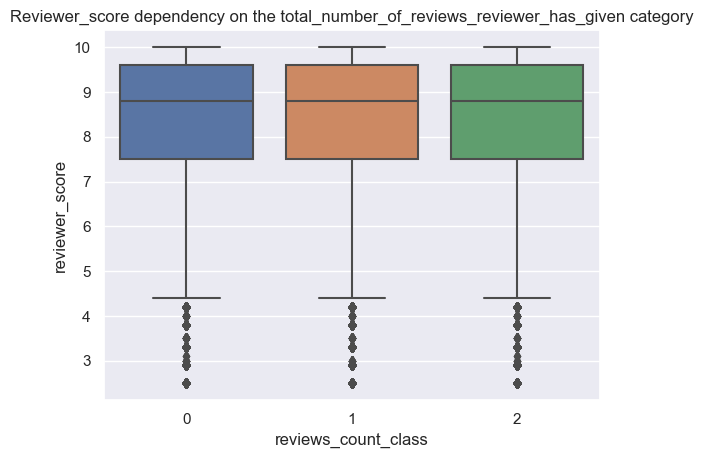

In [85]:
sns.boxplot(x='reviews_count_class', y = 'reviewer_score', 
    data=data.query('sample==1'))
plt.title('Reviewer_score dependency on the total_number_of_reviews_reviewer_has_given category');

**Note:**
- Таким образом, зависимость от количества оставленных отзывов не обнаружена.
Вероятно, можно исключать данный признак и его предшественника.

#### **total_number_of_reviews** & **additional_number_of_scoring**

**additional_number_of_scoring** рассмотрен выше. Здесь рассматривается
в связке с **total_number_of_reviews**

count    515738.000000
mean       2743.743944
std        2317.464868
min          43.000000
25%        1161.000000
50%        2134.000000
75%        3613.000000
max       16670.000000
Name: total_number_of_reviews, dtype: float64

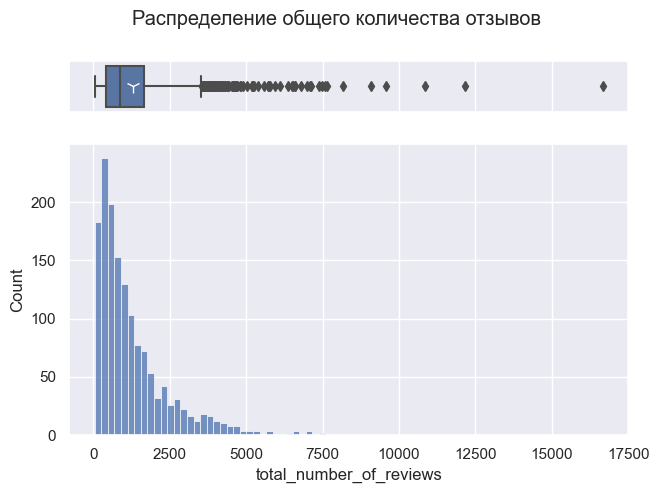

In [86]:
display(data['total_number_of_reviews'].describe())

total_n_reviews = data.groupby(by=['hotel_name', 'hotel_address'])\
    ['total_number_of_reviews'].median().reset_index()
box_hist_plot(total_n_reviews, 'total_number_of_reviews',\
    'Распределение общего количества отзывов')

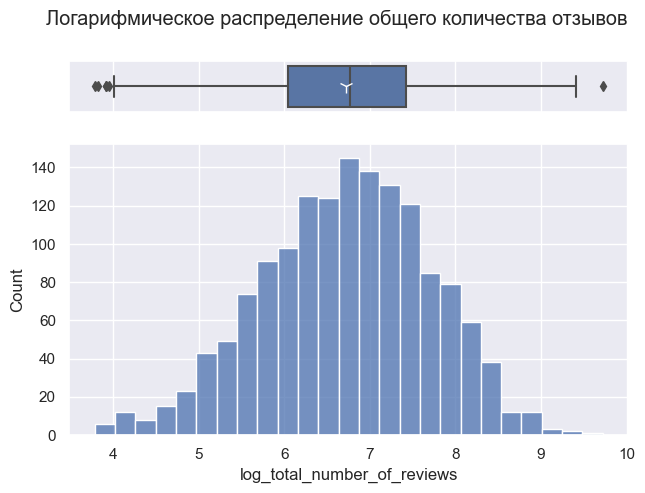

In [87]:
new_column_name = 'log_total_number_of_reviews'
data[new_column_name] =\
    np.log(data['total_number_of_reviews'] + 1)

log_total_number_of_reviews = data.groupby(by=['hotel_name'])\
    [new_column_name].median().reset_index()
box_hist_plot(log_total_number_of_reviews,
    new_column_name,
    'Логарифмическое распределение общего количества отзывов')

Логарифмическое распределение стоит проверить на нормальность

Рассмотрим, как соотносится количество действительных отзывов отеля с количеством отзывов, представленных в датасете. Соотнесём количество отзывов с количеством оценок без отзывов

In [88]:
# Сгруппируем отели и рассмотрим количество отзывов, и количество оценок без
# отзывов
hotels_number_of_reviews = data.groupby(by='hotel_name')\
    .agg({
    'total_number_of_reviews': ['median','count'],
    'additional_number_of_scoring': 'median'
    })
hotels_number_of_reviews.columns = ['_'.join(col) for col\
    in hotels_number_of_reviews.columns]

# Переименуем колонки
hotels_number_of_reviews = hotels_number_of_reviews.rename(columns={
    # Количество отзывов, представленных в датасете
    'total_number_of_reviews_count': 'df_reviews_count', 
    # Количество оценок без отзывов
    'total_number_of_reviews_median': 'total_number_of_reviews',
    'additional_number_of_scoring_median': 'only_marks_count'})

# Выделим процентные характеристики количества отзывов и оценок без отзывов
only_reviews_count = hotels_number_of_reviews['total_number_of_reviews'] -\
        hotels_number_of_reviews['only_marks_count']

hotels_number_of_reviews['df_reviews_percentage_ratio'] =\
    hotels_number_of_reviews['df_reviews_count']\
    /only_reviews_count*100
    
hotels_number_of_reviews['only_reviews_percentage_ratio'] =only_reviews_count\
    /hotels_number_of_reviews['total_number_of_reviews']*100
    
hotels_number_of_reviews['only_marks_percentage_ratio'] =\
    hotels_number_of_reviews['only_marks_count']\
    /hotels_number_of_reviews['total_number_of_reviews']*100
    
print('Процентное соотношение отзывов, представленных в датафрейме, '+\
    'к количеству отзывов с текстом; '+\
    'количества отзывов с текстом к общему количеству отзывов; '
    'а также количества оценок без отзыва к общему количеству отзывов')
display(hotels_number_of_reviews[['df_reviews_percentage_ratio',\
    'only_reviews_percentage_ratio', 'only_marks_percentage_ratio']]\
        .describe())

Процентное соотношение отзывов, представленных в датафрейме, к количеству отзывов с текстом; количества отзывов с текстом к общему количеству отзывов; а также количества оценок без отзыва к общему количеству отзывов


df_reviews_percentage_ratio  only_reviews_percentage_ratio  \
count                  1494.000000                    1494.000000   
mean                     32.174593                      85.226879   
std                      17.826195                       7.244809   
min                       4.819277                      60.294118   
25%                      18.930898                      80.647076   
50%                      26.484290                      87.118865   
75%                      44.132341                      90.829371   
max                      89.473684                      97.959184   

       only_marks_percentage_ratio  
count                  1494.000000  
mean                     14.773121  
std                       7.244809  
min                       2.040816  
25%                       9.170629  
50%                      12.881135  
75%                      19.352924  
max                      39.705882

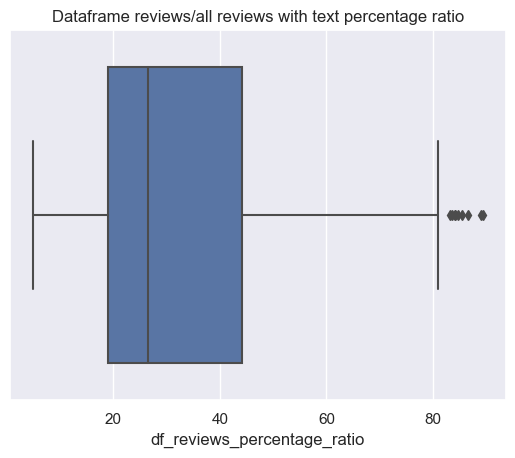

In [89]:
sns.boxplot(x='df_reviews_percentage_ratio',
    data=hotels_number_of_reviews);
plt.title('Dataframe reviews/all reviews with text percentage ratio');

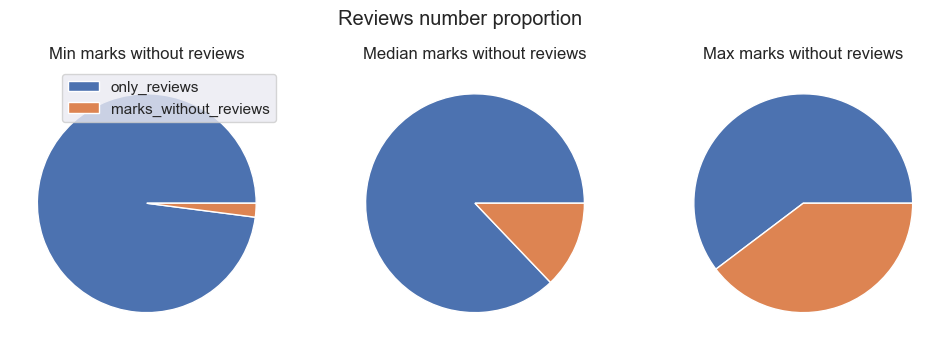

In [90]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
labels = ['only_reviews', 'marks_without_reviews']

pie_data = [hotels_number_of_reviews['only_reviews_percentage_ratio'].max(),
        hotels_number_of_reviews['only_marks_percentage_ratio'].min()]
axes[0].pie(pie_data)
axes[0].set_title('Min marks without reviews');

pie_data = [hotels_number_of_reviews['only_reviews_percentage_ratio'].median(),
        hotels_number_of_reviews['only_marks_percentage_ratio'].median()]
axes[1].pie(pie_data)
axes[1].set_title('Median marks without reviews');

pie_data = [hotels_number_of_reviews['only_reviews_percentage_ratio'].min(),
        hotels_number_of_reviews['only_marks_percentage_ratio'].max()]
axes[2].pie(pie_data)
axes[2].set_title('Max marks without reviews');
axes[0].legend(labels, loc='best');
fig.suptitle('Reviews number proportion');

**Note**:
- Таким образом, выгрузка отзывов не пропорциональна общему количеству отзывов
у всех отелей, об этом говорит наличие разборса в boxplot. 
- Оценки без отзывов составляют малую часть общего количества оценок с отзывами.
Однако, от отеля к отелю это соотношение сильно разнится.
Возможно их соотношение влияет на предсказываемую оценку отеля,
 что дополнительно можно проверить.

**Введём относительное количество оценок без отзывов**

In [91]:
data['relative_additional_number_of_scoring'] =\
    data['additional_number_of_scoring']/data['total_number_of_reviews']

Посмотрим на его распределение

count    515738.000000
mean          0.179050
std           0.075779
min           0.020408
25%           0.109046
50%           0.176425
75%           0.239130
max           0.397059
Name: relative_additional_number_of_scoring, dtype: float64

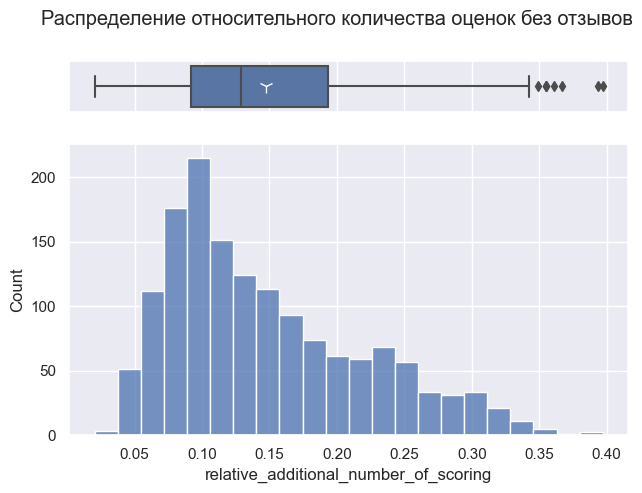

In [92]:
display(data['relative_additional_number_of_scoring'].describe())

rel_add_n_score = data.groupby(by=['hotel_name'])\
    ['relative_additional_number_of_scoring'].median().reset_index()
box_hist_plot(rel_add_n_score, 'relative_additional_number_of_scoring',\
    'Распределение относительного количества оценок без отзывов')

Распределение смещено вправо. Будем считать его ненормальным

Введём категориальный признак, отвечающий за количество оценок без отзывов

In [93]:
data['category_additional_number_of_scoring'] = get_bins_categories(
    data['relative_additional_number_of_scoring'], 10)

Оценим его влияние на рейтинг

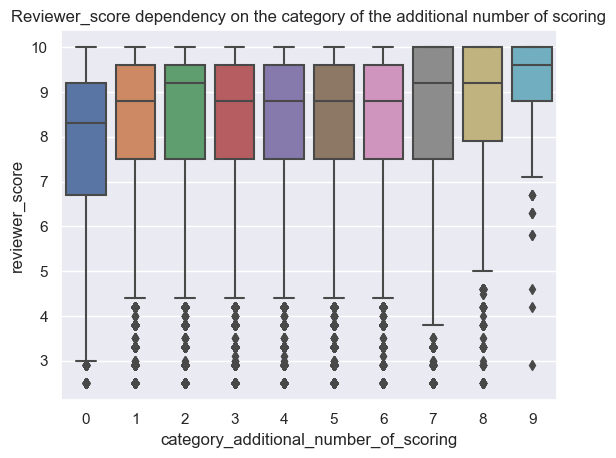

In [94]:
sns.boxplot(x='category_additional_number_of_scoring', y = 'reviewer_score', 
    data=data.query('sample==1'))
plt.title('Reviewer_score dependency on the category of the additional number of scoring');

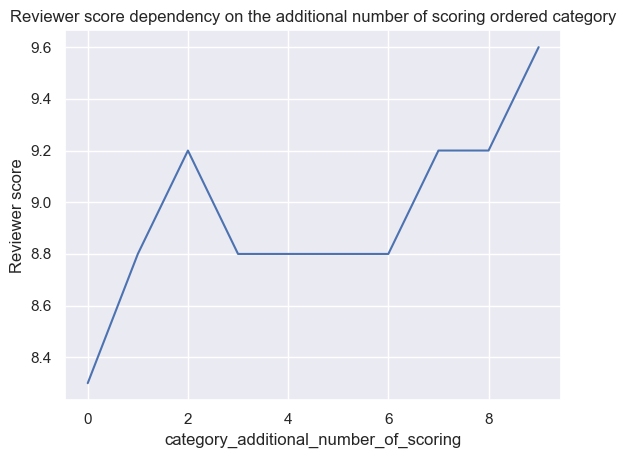

In [95]:
additional_score = data.query('sample==1').groupby(
    by='category_additional_number_of_scoring')\
        ['reviewer_score'].median().reset_index()
# display(additional_score)
additional_score.plot.line(x='category_additional_number_of_scoring', 
    y='reviewer_score', legend=False, ylabel='Reviewer score',
    title='Reviewer score dependency on the additional number of scoring ordered category');

Имеется некоторое положительное неубывающее влияние. Пока оставим переменную

#### **days_since_review** - edited

Количество дней между оставлением отзыва и датой выгрузки. Приведём к числовому формату

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 73 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   hotel_address                                   515738 non-null  object        
 1   additional_number_of_scoring                    515738 non-null  int64         
 2   review_date                                     515738 non-null  datetime64[ns]
 3   average_score                                   515738 non-null  float64       
 4   hotel_name                                      515738 non-null  object        
 5   reviewer_nationality                            515738 non-null  object        
 6   negative_review                                 515738 non-null  object        
 7   review_total_negative_word_counts               515738 non-null  int64         
 8   total_number_of_reviews           

In [97]:
data['days_since_review_int'] = data['days_since_review']\
    .apply(lambda x: int(x.split(' ')[0]))
data['days_since_review_int']

0          13
1         234
2         616
3         656
4         444
         ... 
515733    106
515734    171
515735    543
515736     74
515737    363
Name: days_since_review_int, Length: 515738, dtype: int64

count    515738.000000
mean        354.441932
std         208.928124
min           0.000000
25%         175.000000
50%         353.000000
75%         527.000000
max         730.000000
Name: days_since_review_int, dtype: float64

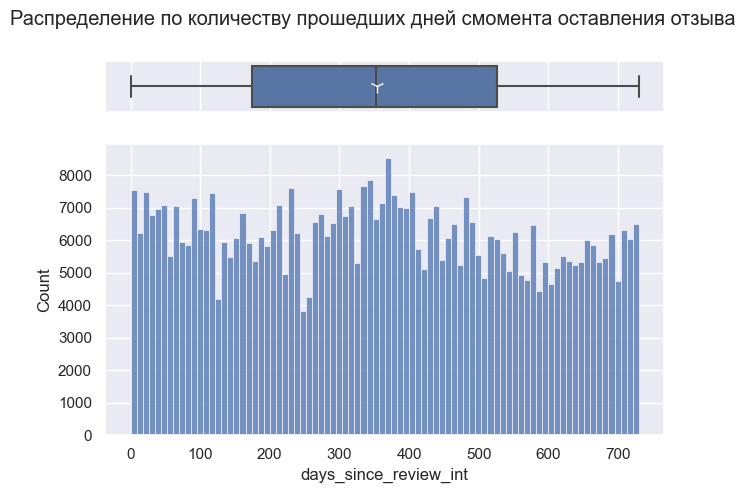

In [98]:
display(data['days_since_review_int'].describe())
box_hist_plot(data=data, x='days_since_review_int',\
    title='Распределение по количеству прошедших дней с'+
    'момента оставления отзыва')

Проверим влияние количества дней с момента отправки отзыва на рейтинг, 
для этого разделим на категории со средней длиной около месяца

In [99]:
data['category_days_since_review'] = get_bins_categories(
    data['days_since_review_int'], 24)

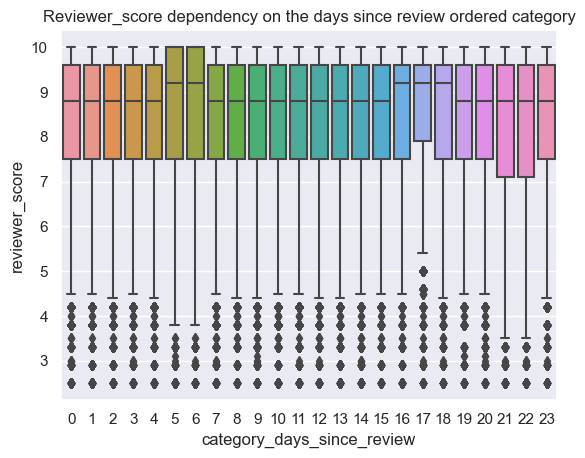

In [100]:
sns.boxplot(x='category_days_since_review', y = 'reviewer_score', 
    data=data.query('sample==1'))
plt.title('Reviewer_score dependency on the days since review ordered category');

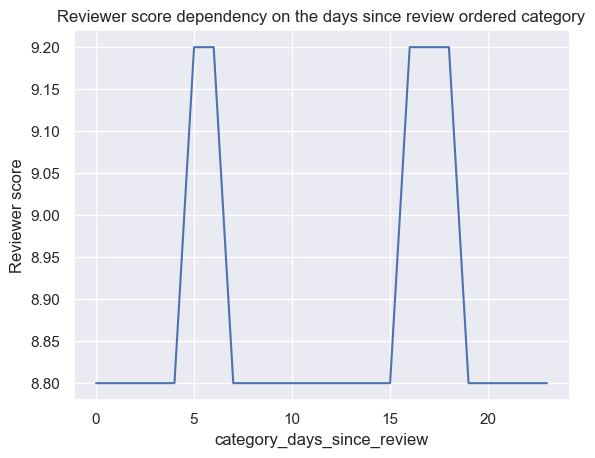

In [101]:
days_score = data.query('sample==1').groupby(
    by='category_days_since_review'
)['reviewer_score'].median().reset_index()
# display(days_score)
days_score.plot.line(x='category_days_since_review', 
    y='reviewer_score', legend=False, ylabel='Reviewer score',
    title='Reviewer score dependency on the days since review ordered category');

**Note:**
- Отзывы примерно равномерно распределены по количеству дней с момента отправки
- Вероятнее всего эти пики связаны с сезонностью, описанной выше. 
В зимнее время рейтинги выставляют выше.

#### **lat** и **lng** -> edited

Эти колонки содержат явные пропуски

In [102]:
lat_nans = data['lat'].isna().sum()/data.shape[0]*100
lng_nans = data['lng'].isna().sum()/data.shape[0]*100
print(f'Доля пропусков широты {round(lat_nans,2)}%, '+\
    f'долготы {round(lng_nans,2)}%')

Доля пропусков широты 0.63%, долготы 0.63%


Рассмотрим, что за отели имеют пропуски

In [103]:
hotels_without_coordinates = data[data['lat'].isna() | data['lng'].isna()]\
    .groupby(by=['hotel_name'])['hotel_name'].count()
display(hotels_without_coordinates)
print('Количество отелей без географических координат:',\
    hotels_without_coordinates.shape[0])

hotel_name
Austria Trend Hotel Schloss Wilhelminenberg Wien    194
City Hotel Deutschmeister                            93
Cordial Theaterhotel Wien                            57
Derag Livinghotel Kaiser Franz Joseph Vienna        147
Fleming s Selection Hotel Wien City                 658
Holiday Inn Paris Montmartre                         55
Hotel Advance                                        28
Hotel Atlanta                                       389
Hotel City Central                                  563
Hotel Daniel Vienna                                 245
Hotel Park Villa                                     61
Hotel Pension Baron am Schottentor                  223
Maison Albar Hotel Paris Op ra Diamond              290
Mercure Paris Gare Montparnasse                      37
NH Collection Barcelona Podium                      146
Renaissance Barcelona Hotel                          33
Roomz Vienna                                         49
Name: hotel_name, dtype: int64

Количество отелей без географических координат: 17


Проверим, может у этих отелей есть координаты, но в других записях?

In [104]:
hotels_without_coordinates_names = list(hotels_without_coordinates.index)
data[data['hotel_name'].isin(hotels_without_coordinates_names) &\
    data['lng'].notna()]

Empty DataFrame
Columns: [hotel_address, additional_number_of_scoring, review_date, average_score, hotel_name, reviewer_nationality, negative_review, review_total_negative_word_counts, total_number_of_reviews, positive_review, review_total_positive_word_counts, total_number_of_reviews_reviewer_has_given, tags, days_since_review, lat, lng, sample, reviewer_score, hotel_country, hotel_city, hotel_name_word_count, log_additional_number_of_scoring, review_month, review_season, winter_review, hotel_rating, is_international, reviewer_country_group, splitted_tags, tags_count, trip_type, is_mobile, night_count, trip_group, room_beds, room_type, negative_review_type, positive_review_type, what_positive, what_negative, pos_tag_count, neg_tag_count, neg_price, neg_room, neg_pillow, neg_other, neg_wifi, neg_bed, neg_breakfast, neg_staff, neg_location, pos_staff, pos_room, pos_clean, pos_breakfast, pos_other, pos_location, pos_bed, pos_rev_neg, neg_rev_neg, pos_rev_neu, neg_rev_neu, pos_rev_pos, neg_rev_pos, pos_rev_compound, neg_rev_compound, log_review_total_negative_word_counts, log_review_total_positive_word_counts, log_total_number_of_reviews_reviewer_has_given, reviews_count_class, log_total_number_of_reviews, relative_additional_number_of_scoring, category_additional_number_of_scoring, days_since_review_int, category_days_since_review]
Index: []

[0 rows x 75 columns]

Таких записей не обранружено

**Note:**
- 17 из 1493 отелей не имеют географических координат
- Имеющийся набор данных можно расширить координатами центров городов и соотнести с городами, извлекаемыми из адреса
- Исходя из координат центра города, а также широты и долготы расположения отеля, можно извлечь расстояние от отеля до центра города
- Пропуски в координатах отелей можно заполнить медианным значением расстояния от центра до отеля

**Дополним данные координатами центров городов**

In [105]:
data['hotel_city'].unique()

array(['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna'],
      dtype=object)

In [106]:
import requests
token = config('YA_TOKEN',default='')
url = 'https://geocode-maps.yandex.ru/1.x'

# Prepare temp column for getting cities and countries
data['city_country'] = data['hotel_city'] + ', '\
    + data['hotel_country']
cities = data['city_country'].unique()

# List of cities locations
cities_loc = []

for city in cities:
    # Get response from yandex
    params = {
        'geocode': city,
        'apikey': token,
        'format': 'json',
        'lang': 'en_US'
    }
    response = requests.get(url, params=params)
    out = response.json()

    # Retrieve location data
    # and object coordinates
    geo_object = out['response']['GeoObjectCollection']\
        ['featureMember'][0]['GeoObject']
    coordinates = geo_object['Point']['pos'].split()
    city_loc = {
        'hotel_city': geo_object['name'],
        'hotel_country': geo_object['metaDataProperty']['GeocoderMetaData']\
            ['AddressDetails']['Country']['CountryName'],
        'center_lng': float(coordinates[0]),
        'center_lat': float(coordinates[1])
        }
    cities_loc.append(city_loc)

# Create df for further merging
cities_loc_df = pd.DataFrame(cities_loc)
display(cities_loc_df)

# Объединим датафреймы
# ПРОВЕРИТЬ!!!
# data = data.merge(cities_loc_df.drop('hotel_country', axis=1), 
# on='hotel_city', how='left')

data = data.merge(cities_loc_df, 
on=['hotel_city', 'hotel_country'], how='left')
data.info()

hotel_city   hotel_country  center_lng  center_lat
0      Milan           Italy    9.189595   45.464183
1  Amsterdam     Netherlands    4.892557   52.373057
2  Barcelona           Spain    2.144449   41.392696
3     London  United Kingdom   -0.127696   51.507351
4      Paris          France    2.351556   48.856663
5     Vienna         Austria   16.363460   48.206487

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 78 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   hotel_address                                   515738 non-null  object        
 1   additional_number_of_scoring                    515738 non-null  int64         
 2   review_date                                     515738 non-null  datetime64[ns]
 3   average_score                                   515738 non-null  float64       
 4   hotel_name                                      515738 non-null  object        
 5   reviewer_nationality                            515738 non-null  object        
 6   negative_review                                 515738 non-null  object        
 7   review_total_negative_word_counts               515738 non-null  int64         
 8   total_number_of_reviews           

**Извлечём расстояния от отелей до центров соответствующих городов**

Для этого применим формулу гаверсинусов

$$\Delta l = 2r\cdot arcsin(\sqrt{hav(\phi_2 - \phi_1) + cos(\phi_1)cos(\phi_2)hav(\lambda_2 - \lambda_1)})$$

где $hav(\theta) = sin^2(\theta/2)$; $\phi_1$, $\phi_2$ - широты точек; 
$\lambda_1$, $\lambda_2$ - долготы точек в радианах

Проверим корректность формулы

In [107]:
# Проверка валидности по расстоянию между Лондоном и Парижем
london_paris = hav_distance(51.507351, -0.127696, 48.856663, 2.351556)
print(f'Лондон-Париж: {london_paris} km')

Лондон-Париж: 343.5180236172188 km


Считает с точностью до километра.
Погрешность вызвана осреднением радиуса Земли.

Вычислим расстояния от центров соответствующих городов до отелей

In [108]:
data['center_distance'] = data.apply(lambda row:\
    hav_distance(row['center_lat'], row['center_lng'],\
        row['lat'], row['lng']), axis=1)

data['center_distance'].describe()

count    512470.000000
mean          3.238442
std           2.527476
min           0.072794
25%           1.506401
50%           2.594047
75%           4.091961
max          17.145189
Name: center_distance, dtype: float64

Медианное расстояние от центра города до гостиницы - 2.59 км. 
Заполним пропуски этим расстоянием

In [109]:
data['center_distance'] =\
    data['center_distance'].fillna(data['center_distance'].median())
data['center_distance'].describe()

count    515738.000000
mean          3.234359
std           2.519975
min           0.072794
25%           1.511574
50%           2.594047
75%           4.082277
max          17.145189
Name: center_distance, dtype: float64

Оценим распределение

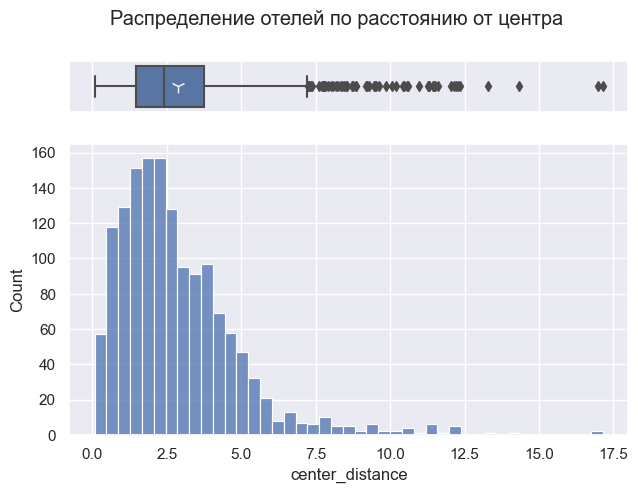

In [110]:
center_distance = data.groupby(by=['hotel_name'])\
    ['center_distance'].median().reset_index()
box_hist_plot(center_distance, 'center_distance',\
    'Распределение отелей по расстоянию от центра')

Распределение похоже на логнормальное. Проверим

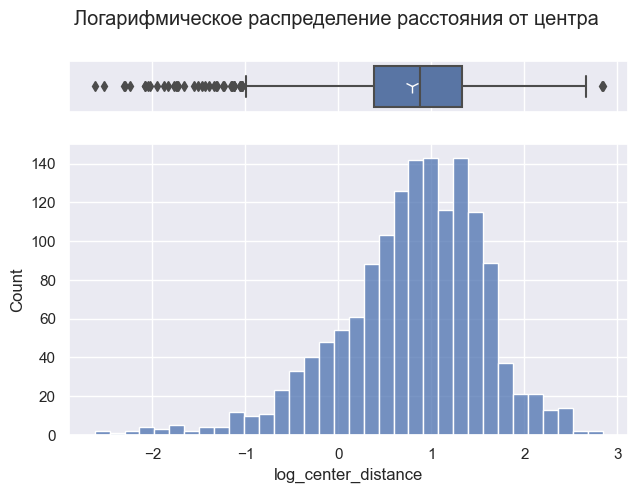

In [111]:
new_column_name = 'log_center_distance'
data[new_column_name] =\
    np.log(data['center_distance'])

log_center_distance = data.groupby(by=['hotel_name'])\
    [new_column_name].median().reset_index()
box_hist_plot(log_center_distance,
    new_column_name,
    'Логарифмическое распределение расстояния от центра')

Проверим на нормальность ниже

**Note:** 
Что касается заполнения пропусков координат, то в дальнейшем можно было бы 
учесть почтовые индексы.

Заполним пропуски lat, lng координатами центров соответствующих городов

Заполнение пропусков данными городов ведёт к пропускам в submission...

In [112]:
data['lat'] = data['lat'].fillna(data['center_lat'])
data['lng'] = data['lng'].fillna(data['center_lng'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 80 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   hotel_address                                   515738 non-null  object        
 1   additional_number_of_scoring                    515738 non-null  int64         
 2   review_date                                     515738 non-null  datetime64[ns]
 3   average_score                                   515738 non-null  float64       
 4   hotel_name                                      515738 non-null  object        
 5   reviewer_nationality                            515738 non-null  object        
 6   negative_review                                 515738 non-null  object        
 7   review_total_negative_word_counts               515738 non-null  int64         
 8   total_number_of_reviews           

### Очистка данных (data cleaning)

Проводится: 
- удаление/разметка дубликатов;
- заполнение пропусков (при необходимости);
- удаление/разметка выбросов и аномалий

#### Дубликаты

Удалим только дубликаты в train_df, так как в submission дубликаты должны остаться нетронутыми. Иначе возникнут проблемы оценки submission

In [113]:
train_df = data.query('sample == 1')
columns_for_duplicates = list(train_df.columns)
columns_for_duplicates =[x for x in columns_for_duplicates if x\
    not in ['splitted_tags', 'what_positive', 'what_negative']] 
dup_count = train_df.duplicated(columns_for_duplicates).sum()
print('Количество дубликатов:', dup_count)
print('Размер всего датафрейма до удаления дубликатов:', data.shape[0])
train_df = train_df.drop_duplicates(columns_for_duplicates)
data = data.query('sample == 0')
data = pd.concat([data, train_df]).reset_index(drop=True)
print('Дубликаты удалены. Размер датафрейма:', data.shape[0])


Количество дубликатов: 308
Размер всего датафрейма до удаления дубликатов: 515738
Дубликаты удалены. Размер датафрейма: 515430


#### Пропуски

- Предварительный анализ данных показал, что явные пропуски содержатся только в **lat** и **lng** - они исключены в новом столбце расстояния от центра города
- Неявные пропуски имеются в **positive_review** и **negative_review**

Проверим отсутствие пропусков

In [114]:
if not data.isna().any().any():
    print('Пропусков нет')
else:
    print('ИМЕЮТСЯ ПРОПУСКИ!')

Пропусков нет


#### Выбросы и аномалии

- Необходимо сделать разные имена для Отеля Регина из разных стран - выполнено

- Можно отметить выбросы в колонке additional_number_of_scoring, или же перейти к относительному количеству оценок без отзывов - последнее и было выполнено

- Выбросы в остальных колонках убираются засчёт введения категориального признака или логарифмирования

## 3. Разведывательный анализ данных (EDA)

Как правило, включает в себя:
- **Проверку статистических гипотез**.
Цель - сформировать корректное с точки зрения статистики представление о виде
неизвестного распределения генеральной совокупности,
о параметрах известных распределений или о статистической значимости разницы 
этих параметров при различных значениях независимой переменной;
- **Проектирование признаков (feature engineering)**:
    - *Создание новых признаков (feature generating)*. 
    Цель - создать более сильные признаки как из существующих данных, 
    так и из внешних источников; путём комбинации нескольких и т.д.
    - *Преобразование признаков (feature transformation)*.
    Цель - подготовить признаки для обучения и 
    повысить качество разрабатываемой модели:
        - Масштабирование, логарифмирование числовых признаков 
        (метод зависит от вида распределения [см. предыдущий пункт]);
        - Уменьшение числа уникальных значений;
        - Кодирование признаков (Ordered-, OneHot-, Binary- encoding).
        Для преобразования категориальные данные в формат, 
        пригодный для обучения - числовой;
- **Отбор признаков (feature selection)**. 
Цель - решение проблемы "проклятия размерности" и повышение качества 
разрабатываемой модели:
    - *выделить значимые признаки*, которые сильнее всего влияют на целевую 
    функцию (target) (оценка значимости признаков статистическими тестами - 
    feature importances);
    - *исключить мультиколлинеарные признаки*, сильно зависимые между собой;
    - *исключить неинформативные признаки*,
    когда большинство записей уникальны, либо наоборот, имеют одно значение.

### Проверка на нормальность

Проверка на нормальность проводится тестом Д Агостино, так как перед нами выборки с большим количеством наблюдений, чем 1000.

In [115]:
check_norm = {
    'log_additional_number_of_scoring': log_addit_n_scoring
    ['log_additional_number_of_scoring'],
    'average_score': average_score['average_score'],
    'log_review_total_negative_word_counts': 
        log_review_total_negative_word_counts
        ['log_review_total_negative_word_counts'],
    'log_review_total_positive_word_counts': 
        log_review_total_positive_word_counts
        ['log_review_total_positive_word_counts'],
    'log_total_number_of_reviews_reviewer_has_given': 
        log_total_number_of_reviews_reviewer_has_given
        ['log_total_number_of_reviews_reviewer_has_given'],
    'log_total_number_of_reviews': log_total_number_of_reviews
    ['log_total_number_of_reviews'],
    'log_center_distance': log_center_distance['log_center_distance']
}

In [116]:
# Введём уровень значимости
alpha = .01

for elem in check_norm:
    _, p = normaltest(check_norm[elem])
    print(elem)
    print("p = {:g}".format(p))

    if p < alpha:
        print('Отвергаем гипотезу H0 -> Данные НЕнормально распределены')
    else:
        print('Нельзя отвергнуть гипотезу H0 -> Данные распределены нормально')

log_additional_number_of_scoring
p = 0.262926
Нельзя отвергнуть гипотезу H0 -> Данные распределены нормально
average_score
p = 1.60829e-20
Отвергаем гипотезу H0 -> Данные НЕнормально распределены
log_review_total_negative_word_counts
p = 1.09129e-58
Отвергаем гипотезу H0 -> Данные НЕнормально распределены
log_review_total_positive_word_counts
p = 0.00797503
Отвергаем гипотезу H0 -> Данные НЕнормально распределены
log_total_number_of_reviews_reviewer_has_given
p = 0.00449259
Отвергаем гипотезу H0 -> Данные НЕнормально распределены
log_total_number_of_reviews
p = 0.00118797
Отвергаем гипотезу H0 -> Данные НЕнормально распределены
log_center_distance
p = 4.21041e-37
Отвергаем гипотезу H0 -> Данные НЕнормально распределены


Таким образом, можем полагать, что нормально распределен только логарифм 
количества оценок без отзывов

### Создание новых признаков (feature generating)

Признаки создавались в разделе "2. Предварительный анализ и подготовка данных".

### Преобразование признаков (feature transformation)
Масштабирование числовых, кодирование категориальных признаков и т.д.

**Масштабирование числовых признаков**

Можно было бы применить *стандартизацию* для log_additional_number_of_scoring,
для остальных *нормализацию*: 
- *RobustScaler* для большинства признаков (имеющих выбросы), 
- *MinMaxScaler* был бы применим при отсутсвии выбросов.

Но так как для большинства применяется RobustScaler, применим его везде.

In [117]:
# Инициализируем стандартизатор
#s_scaler = preprocessing.StandardScaler()
# Инициализируем нормализаторы
# Min-Max Scaler
#mm_scaler = preprocessing.MinMaxScaler()

# RobustScaler
r_scaler = preprocessing.RobustScaler()

# Проведём стандартизацию
# s_cols = ['log_additional_number_of_scoring']
# data[s_cols] =\
#     s_scaler.fit_transform(data[s_cols]\
#         .values.reshape(-1, 1))

# Проведём нормализацию для остальных колонок
# r_cols = [
#     'additional_number_of_scoring',
#     'review_total_negative_word_counts', 'review_total_positive_word_counts',
#     'total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews',
#     'center_distance'
#     ]
# mm_cols = [
#     'average_score', 
#     'log_review_total_negative_word_counts', 
#     'log_review_total_positive_word_counts', 
#     'log_total_number_of_reviews_reviewer_has_given', 
#     'log_total_number_of_reviews', 'relative_additional_number_of_scoring', 
#     'days_since_review_int', 'lat', 'lng', 'center_lng', 'center_lat', 
#     'log_center_distance'
#     ]

r_cols = [
    'log_additional_number_of_scoring', 'additional_number_of_scoring',
    'review_total_negative_word_counts', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews',
    'center_distance', 'average_score', 
    'log_review_total_negative_word_counts', 
    'log_review_total_positive_word_counts', 
    'log_total_number_of_reviews_reviewer_has_given', 
    'log_total_number_of_reviews', 'relative_additional_number_of_scoring', 
    'days_since_review_int', 'lat', 'lng', 'center_lng', 'center_lat', 
    'log_center_distance'
]

# data[mm_cols] = r_scaler.fit_transform(data[mm_cols])

data[r_cols] = r_scaler.fit_transform(data[r_cols])

data.describe()

additional_number_of_scoring  average_score  \
count                 515430.000000  515430.000000   
mean                       0.318280      -0.003386   
std                        1.019591       0.782905   
min                       -0.694501      -4.571429   
25%                       -0.352342      -0.428571   
50%                        0.000000       0.000000   
75%                        0.647658       0.571429   
max                        4.765784       2.000000   

       review_total_negative_word_counts  total_number_of_reviews  \
count                      515430.000000            515430.000000   
mean                            0.454276                 0.246869   
std                             1.413857                 0.937632   
min                            -0.428571                -0.845874   
25%                            -0.333333                -0.393608   
50%                             0.000000                 0.000000   
75%                             0.666667                 0.606392   
max                            19.000000                 5.880259   

       review_total_positive_word_counts  \
count                      515430.000000   
mean                            0.398669   
std                             1.282542   
min                            -0.647059   
25%                            -0.352941   
50%                             0.000000   
75%                             0.647059   
max                            22.588235   

       total_number_of_reviews_reviewer_has_given            lat  \
count                               515430.000000  515430.000000   
mean                                     0.595031      -0.625886   
std                                      1.576965       1.047915   
min                                     -0.285714      -3.079521   
25%                                     -0.285714      -0.995063   
50%                                      0.000000       0.000000   
75%                                      0.714286       0.004937   
max                                     50.285714       0.272542   

                 lng        sample  reviewer_score  ...  \
count  515430.000000  515430.00000   515430.000000  ...   
mean        0.576567       0.74985        6.296711  ...   
std         0.936672       0.43310        3.902970  ...   
min        -0.078171       0.00000        0.000000  ...   
25%        -0.032753       0.00000        0.000000  ...   
50%         0.000000       1.00000        7.900000  ...   
75%         0.967247       1.00000        9.600000  ...   
max         3.292052       1.00000       10.000000  ...   

       log_review_total_positive_word_counts  \
count                          515430.000000   
mean                               -0.031223   
std                                 0.781504   
min                                -1.849254   
25%                                -0.515836   
50%                                 0.000000   
75%                                 0.484164   
max                                 2.602082   

       log_total_number_of_reviews_reviewer_has_given  reviews_count_class  \
count                                   515430.000000        515430.000000   
mean                                         0.089538             1.057878   
std                                          0.541086             0.808867   
min                                         -0.528321             0.000000   
25%                                         -0.528321             0.000000   
50%                                          0.000000             1.000000   
75%                                          0.471679             2.000000   
max                                          2.295571             2.000000   

       log_total_number_of_reviews  relative_additional_number_of_scoring  \
count                515430.000000                          515430.000000   
mean                     -0.065777                               0

**Кодирование категориальных признаков**
Порядковые категориальные признаки уже закодированы. Остались номинальные

In [118]:
nom_cat_cols = ['hotel_country', 'hotel_city', 'review_season',
    'reviewer_country_group', 'trip_type', 
    'negative_review_type', 'positive_review_type']
data = pd.get_dummies(data, columns=nom_cat_cols)

### Отбор признаков (feature selection)
Для категориальных: 
- Хи-квадрат?
- ANOVA

Для непрерывных: 
- ANOVA?
- Корреляция Спирмена?

Будем использовать данные из датасета train

Выделим порядковые категориальные и числовые признаки

In [119]:
num_cols = r_cols.copy()
# Добавим оценку тональности текста
for key in sent_keys:
    num_cols.append('pos_rev_'+key)
    num_cols.append('neg_rev_'+key)
    
# num_cols.extend(s_cols)
print(f'Числовые признаки, {len(num_cols)}:')
print(num_cols)

set_object_cols = set(data.dtypes[(data.dtypes == 'datetime64[ns]')\
    | (data.dtypes == 'object')].index)

cat_cols = list(set(data.columns) - set(num_cols) - set_object_cols\
    - set([TARGET_NAME, 'sample']))
print(f'Категориальные признаки, {len(cat_cols)}:')
print(cat_cols)

Числовые признаки, 27:
['log_additional_number_of_scoring', 'additional_number_of_scoring', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews', 'center_distance', 'average_score', 'log_review_total_negative_word_counts', 'log_review_total_positive_word_counts', 'log_total_number_of_reviews_reviewer_has_given', 'log_total_number_of_reviews', 'relative_additional_number_of_scoring', 'days_since_review_int', 'lat', 'lng', 'center_lng', 'center_lat', 'log_center_distance', 'pos_rev_neg', 'neg_rev_neg', 'pos_rev_neu', 'neg_rev_neu', 'pos_rev_pos', 'neg_rev_pos', 'pos_rev_compound', 'neg_rev_compound']
Категориальные признаки, 63:
['reviewer_country_group_ungrouped', 'pos_tag_count', 'hotel_country_Austria', 'night_count', 'reviewer_country_group_northern_europe', 'review_month', 'winter_review', 'neg_breakfast', 'neg_price', 'trip_type_leisure', 'review_season_autumn', 'reviewer_country_group_west

Разделим датасет на признаки и целевую функцию

In [120]:
hotels = data.query('sample == 1')
X = hotels.drop(TARGET_NAME, axis=1)
y = hotels[TARGET_NAME]

**Тесты на сравнение выборок**

Сравним числовые признаки

neg_rev_pos                                          4.992733
days_since_review_int                                7.372460
pos_rev_neu                                          7.956941
center_lat                                          18.702715
lat                                                 18.780457
center_lng                                          22.443713
lng                                                 22.811424
relative_additional_number_of_scoring               32.105714
log_additional_number_of_scoring                    40.295462
center_distance                                     43.008458
additional_number_of_scoring                        49.875462
total_number_of_reviews                             63.454619
total_number_of_reviews_reviewer_has_given          71.471261
log_center_distance                                 74.659581
log_total_number_of_reviews                         77.425742
log_total_number_of_reviews_reviewer_has_given      92.895091
pos_rev_

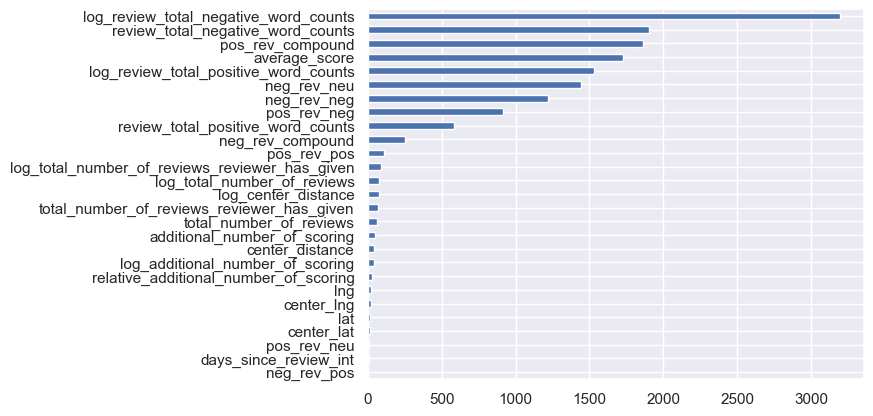

In [121]:
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
display(imp_num)

Сравним категориальные признаки

negative_review_type_negative                    2957.723608
negative_review_type_no_negative                 2957.723608
neg_other                                        2609.531694
neg_room                                         1906.667778
hotel_rating                                     1298.510037
neg_tag_count                                    1226.321342
positive_review_type_no_positive                 1045.285671
positive_review_type_positive                    1045.285671
pos_staff                                         754.000291
neg_staff                                         748.787923
pos_tag_count                                     605.060498
pos_other                                         499.670038
neg_bed                                           449.597139
pos_room                                          324.129682
neg_breakfast                                     164.771501
neg_price                                         155.664781
trip_type_leisure       

<AxesSubplot:>

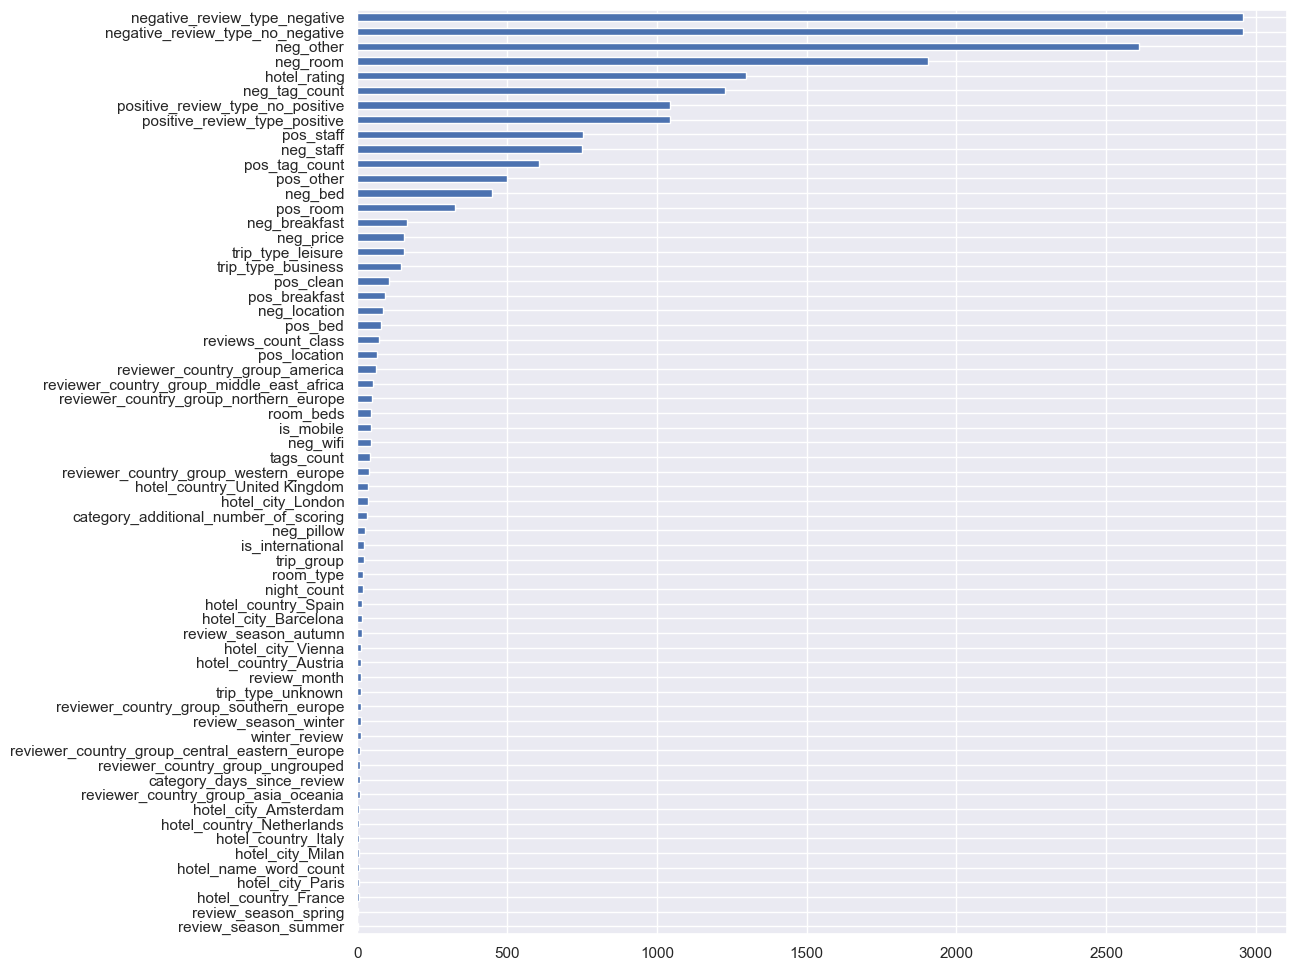

In [122]:
# from sklearn.feature_selection import chi2 # хи-квадрат
# Выдаёт ошибку при его использовании для review_score

# Логичнее тест f_classif, так как таргет - числовой признак
imp_cat = pd.Series(f_classif(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
display(imp_cat.sort_values(ascending=False).head(60))

fis, ax = plt.subplots(1,1, figsize=(12,12))
imp_cat.plot(kind = 'barh', ax=ax)

Пары для эксперимента, что оказывает большее влияние:
- average_score/hotel_rating,
- log_total_number_of_reviews_reviewer_has_given/reviews_count_class,
- category_additional_number_of_scoring/additional_number_of_scoring
/log_additional_number_of_scoring/relative_additional_number_of_scoring,

**Корреляционный анализ. Отбор по мультиколлинеарности**

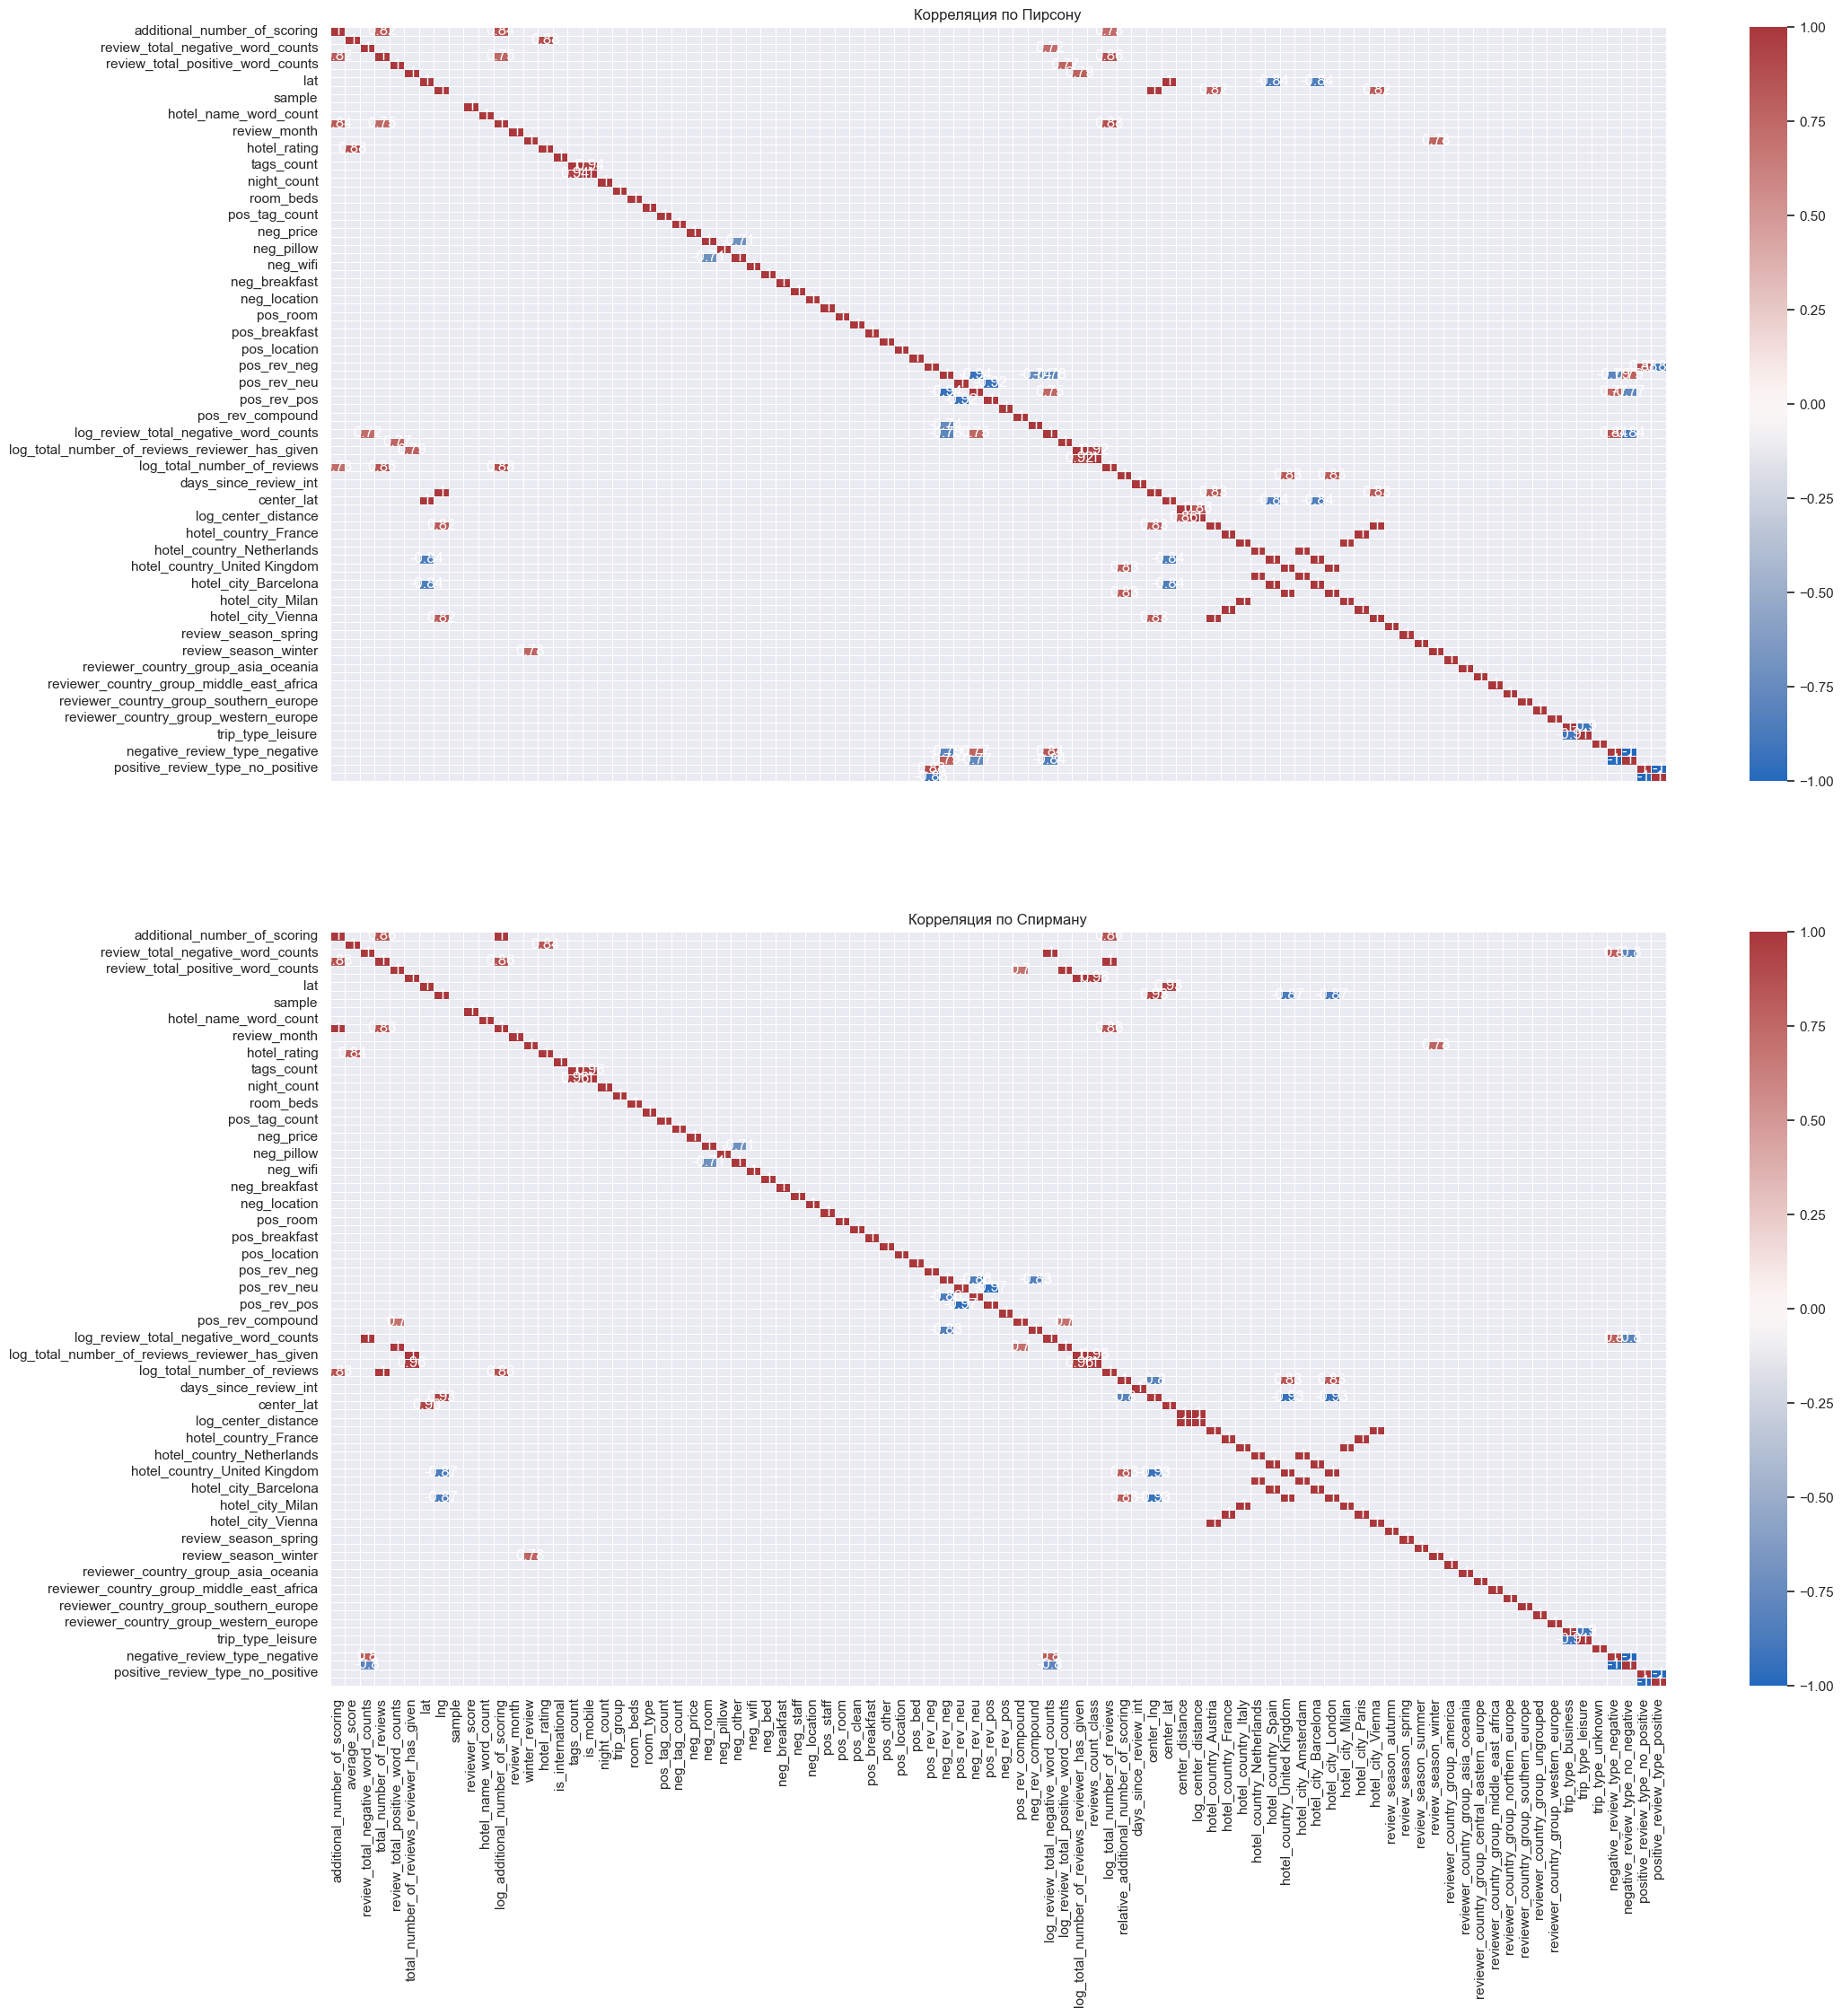

In [123]:
hotels = data.query('sample == 1')
# Убираем предупреждения
import warnings
warnings.filterwarnings("ignore")

pirson_corr = hotels.corr()
spearman_corr = hotels.corr(method='spearman')

# Строим корреляционные графики
fig, (pearson_axes, spearmen_axes) = plt.subplots(2,1, figsize=(24,24));
sns.heatmap(pirson_corr[abs(pirson_corr) >=0.7], vmin=-1, vmax=1, 
            annot=True, ax=pearson_axes, linewidths=.5, cmap="vlag");
sns.heatmap(spearman_corr[abs(spearman_corr) >=0.7], vmin=-1, vmax=1,\
    annot=True, ax=spearmen_axes, linewidths=.5, cmap="vlag");
# Настраиваем графики
pearson_axes.set_title('Корреляция по Пирсону');
pearson_axes.set_xticks([])
spearmen_axes.set_title('Корреляция по Спирману');

**Correlation Notes:**
- Наблюдается сильная скоррелированность 'total_number_of_reviews' и 'additional_number_of_scoring'. При этом связь обоих параметров с 'review_score' почти отсутствует. Убирается скоррелированность при делении 'additional..' на 'total..'. Исходные колонки можно удалить.
- hotel_rating и average_score - надо оставить что-то одно, чтобы исключить мультиколлинеарность.
- Reviews_count_class и Total_number_of_reviews_reviewer_has_hiven - нужно также оставить что-то одно.
- Review_month и winter_review - оставить одно
- Lat/Lng и center_lat/center_lng - оставить одно
- Возможно, для 'total_positive_words_count' и 'total_negative_words_count' имеет смысл ввести соотношение количества слов позитивного/негативного отзывов. Как тогда быть с делением на ноль?..
- Наблюдается прямая связь количества слов в положительном отзыве к выставленной оценке и обратная связь количества слов в отрицательном отзыве к выставленной оценке
- Средняя оценка отеля и оценка в отзыве также скоррелированы
- Неожиданно наблюдать корреляцию широты (прямая) и долготы (обратная) расположения отеля и количества оценок без отзывов. Имеет смысл проанализировать детальнее эту взаимосвязь.

Первая итерация. Итого, с точки зрения корреляции Спирмена c целевой функцией (reviewer_score) важны average_score/hotel_rating, и review_total_negative/total_positive_words_count

**Первая итерация:**

Сильные корреляции (Мультиколлинеарность):
- Колонки average_score и hotel_rating, нужно оставить одну, можно
проэкспериментировать. Эксперимент показал, что average_score лучше;
- lat по Пирсону с hotel_city_Barcelona
- lng по Пирсону с hotel_city_Viena
- lng по Спирману с hotel_city_London
- log_additional_number_of_scoring с log_total_number_of_reviews
- relative_additional_number_of_scoring с hotel_city_London

Проведённые эксперименты показали, что:
- average_score лучше
- признаки городов лучше широты и долготы
- вариации additional_number_of_scoring хуже

#### Удалим лишние колонки. Шаг 1

In [124]:
drop_cols_1 = ['review_season_summer', 'review_season_spring',
    'hotel_name_word_count', 'winter_review', 'hotel_country_France',
    'hotel_country_Italy', 'hotel_country_Netherlands', 
    'hotel_country_Austria', 'hotel_country_Spain', 
    'hotel_country_United Kingdom',
    'days_since_review_int', 'center_distance',
    'review_total_negative_word_counts', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews',
    'additional_number_of_scoring', 'center_lat', 'center_lng',
    'reviews_count_class']

# Колонки, удаляемые после первой оптимизации
drop_cols_2 = ['hotel_rating', 'lat', 'lng',
    'log_additional_number_of_scoring',
    'relative_additional_number_of_scoring']

# Колонки, имеющие явную мультиколлинеарность
drop_cols_3 = ['positive_review_type_positive',
    'negative_review_type_negative', 'trip_type_business',
    'trip_type_unknown']


data = data.drop(drop_cols_1, axis=1)
data = data.drop(drop_cols_2, axis=1)
data = data.drop(drop_cols_3, axis=1)
data.info()

hotels = data.query('sample == 1')
X = hotels.drop(TARGET_NAME, axis=1)
y = hotels[TARGET_NAME]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515430 entries, 0 to 515429
Data columns (total 75 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   hotel_address                                   515430 non-null  object        
 1   review_date                                     515430 non-null  datetime64[ns]
 2   average_score                                   515430 non-null  float64       
 3   hotel_name                                      515430 non-null  object        
 4   reviewer_nationality                            515430 non-null  object        
 5   negative_review                                 515430 non-null  object        
 6   positive_review                                 515430 non-null  object        
 7   tags                                            515430 non-null  object        
 8   days_since_review                 

Ниже будут удаляться

Проверка мультиколлинеарности. Шаг 2

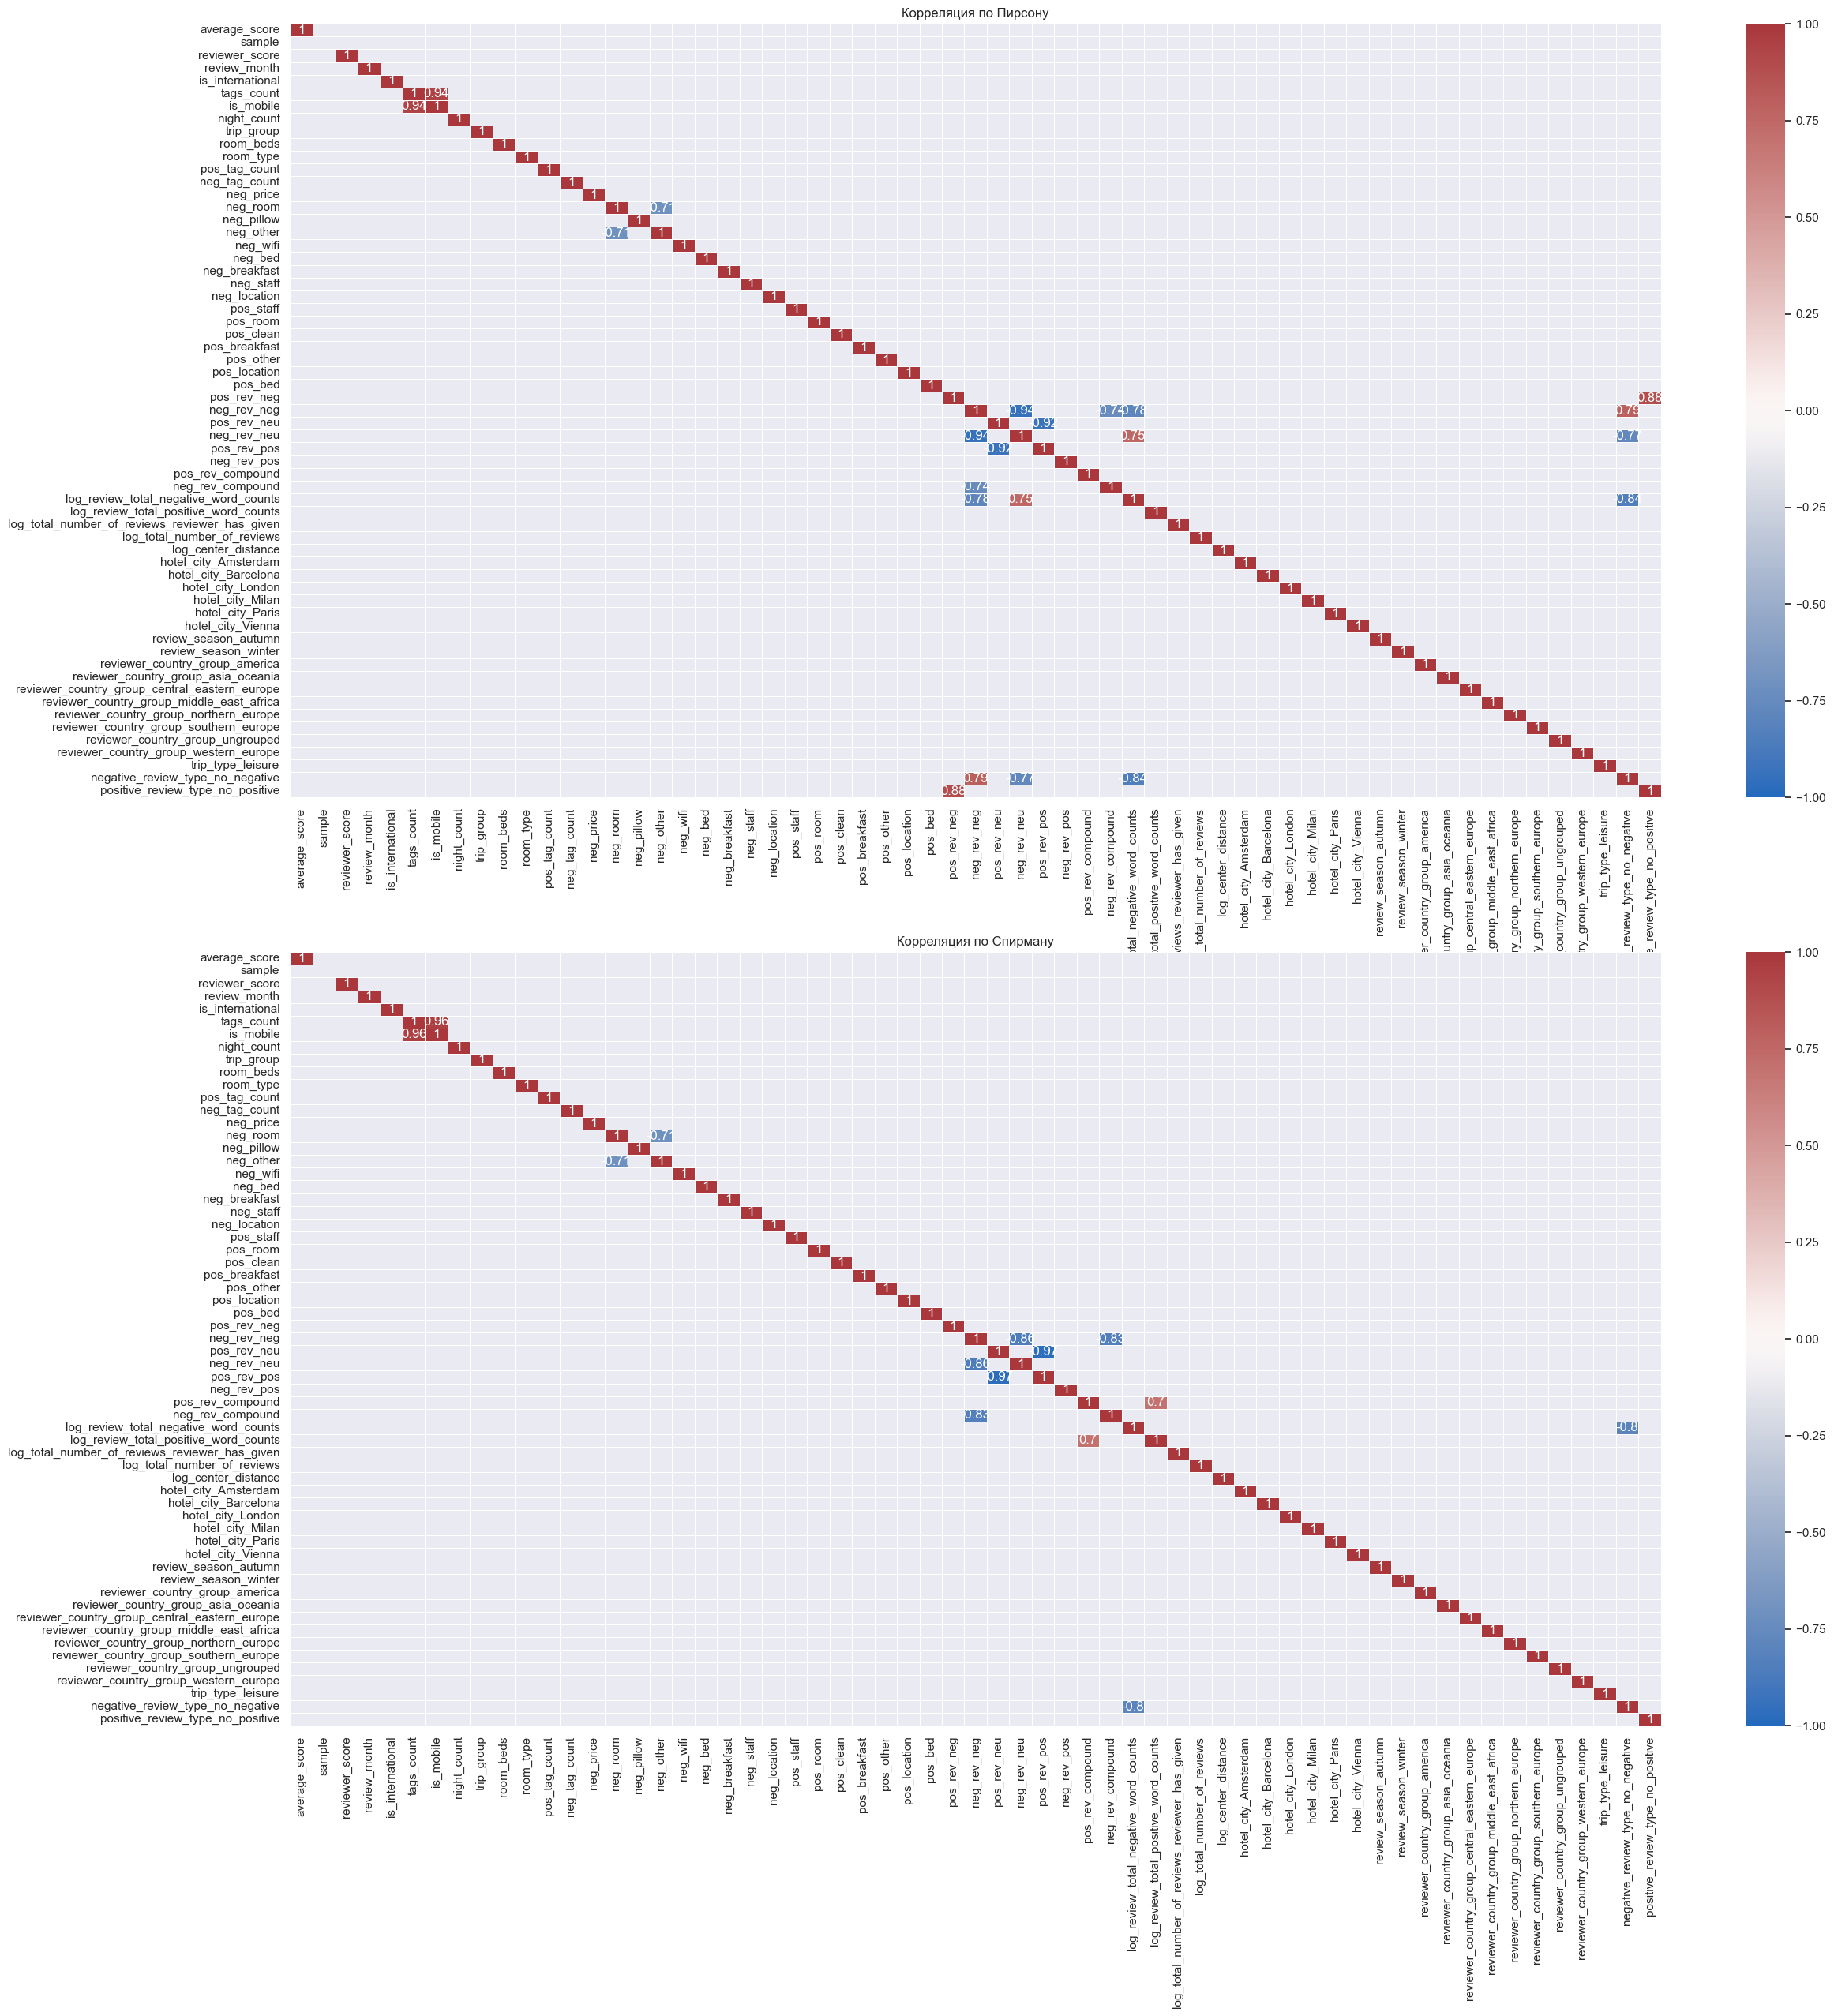

In [127]:
hotels = data.query('sample == 1')
# Убираем предупреждения
import warnings
warnings.filterwarnings("ignore")

pirson_corr = hotels.corr()
spearman_corr = hotels.corr(method='spearman')

# Строим корреляционные графики
fig, (pearson_axes, spearmen_axes) = plt.subplots(2,1, figsize=(28,28));
sns.heatmap(pirson_corr[abs(pirson_corr) >=0.7], vmin=-1, vmax=1, 
            annot=True, ax=pearson_axes, linewidths=.5, cmap="vlag");
sns.heatmap(spearman_corr[abs(spearman_corr) >=0.7], vmin=-1, vmax=1,\
    annot=True, ax=spearmen_axes, linewidths=.5, cmap="vlag");
# Настраиваем графики
pearson_axes.set_title('Корреляция по Пирсону');
# pearson_axes.set_xticks([])
spearmen_axes.set_title('Корреляция по Спирману');

Значимость оставшихся категориальных признаков

In [ ]:
# Логичнее тест f_classif, так как таргет - числовой признак
cat_cols = set(cat_cols).intersection(set(X.columns))
imp_cat = pd.Series(f_classif(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
display(imp_cat.sort_values(ascending=False).head(60))

fis, ax = plt.subplots(1,1, figsize=(12,12))
imp_cat.plot(kind = 'barh', ax=ax)

**Note (вторая итерация):**

По мультиколлинеарности:
- is_mobile (решено убрать) и tags_count
- neg_room (решено убрать) и neg_other
- negative_review_type_no_negative vs log_review_total_negative_word_counts (решено убрать)
Также убираем pos_rev_neg, neg_rev_neg; pos_rev_neu, neg_rev_neu; 

Колонки удаления второй итерации 
(Мультиколлинеарность и исключение малозначащих)

In [128]:
var_drop_cols = ['is_mobile', 'neg_room', 'negative_review_type_no_negative',
    'pos_rev_neg', 'neg_rev_neg', 'pos_rev_neu', 'neg_rev_neu',
    'log_review_total_positive_word_counts'
    # 'hotel_city_Paris', 'hotel_city_Milan', 'hotel_city_Amsterdam',
    # 'reviewer_country_group_asia_oceania', 'category_days_since_review',
    # 'reviewer_country_group_ungrouped',
    # 'reviewer_country_group_central_eastern_europe',
    # 'review_season_winter', 'reviewer_country_group_southern_europe',
    # 'review_month', 'hotel_city_Vienna', 'review_season_autumn',
    # 'hotel_city_Barcelona', 'hotel_city_London'
    ]

data = data.drop(var_drop_cols, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515430 entries, 0 to 515429
Data columns (total 68 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   hotel_address                                   515430 non-null  object        
 1   review_date                                     515430 non-null  datetime64[ns]
 2   average_score                                   515430 non-null  float64       
 3   hotel_name                                      515430 non-null  object        
 4   reviewer_nationality                            515430 non-null  object        
 5   negative_review                                 515430 non-null  object        
 6   positive_review                                 515430 non-null  object        
 7   tags                                            515430 non-null  object        
 8   days_since_review                 

Проверка мультиколинеарности. Шаг 3

### Финальная чистка:

In [131]:
# убираем признаки, которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, 
# просто выберем их и удалим
object_columns = [s for s in data.columns if data[s].dtypes in\
    ['object', 'category', 'datetime64[ns]']]
data.drop(object_columns, axis = 1, inplace=True)

# заполняем пропуски самым простым способом
# data = data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515430 entries, 0 to 515429
Data columns (total 53 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   average_score                                   515430 non-null  float64
 1   sample                                          515430 non-null  int64  
 2   reviewer_score                                  515430 non-null  float64
 3   review_month                                    515430 non-null  int64  
 4   is_international                                515430 non-null  int64  
 5   tags_count                                      515430 non-null  int64  
 6   night_count                                     515430 non-null  int64  
 7   trip_group                                      515430 non-null  int64  
 8   room_beds                                       515430 non-null  int64  
 9   room_type                 

### Финальная проверка отсутствия мультиколлинеарности

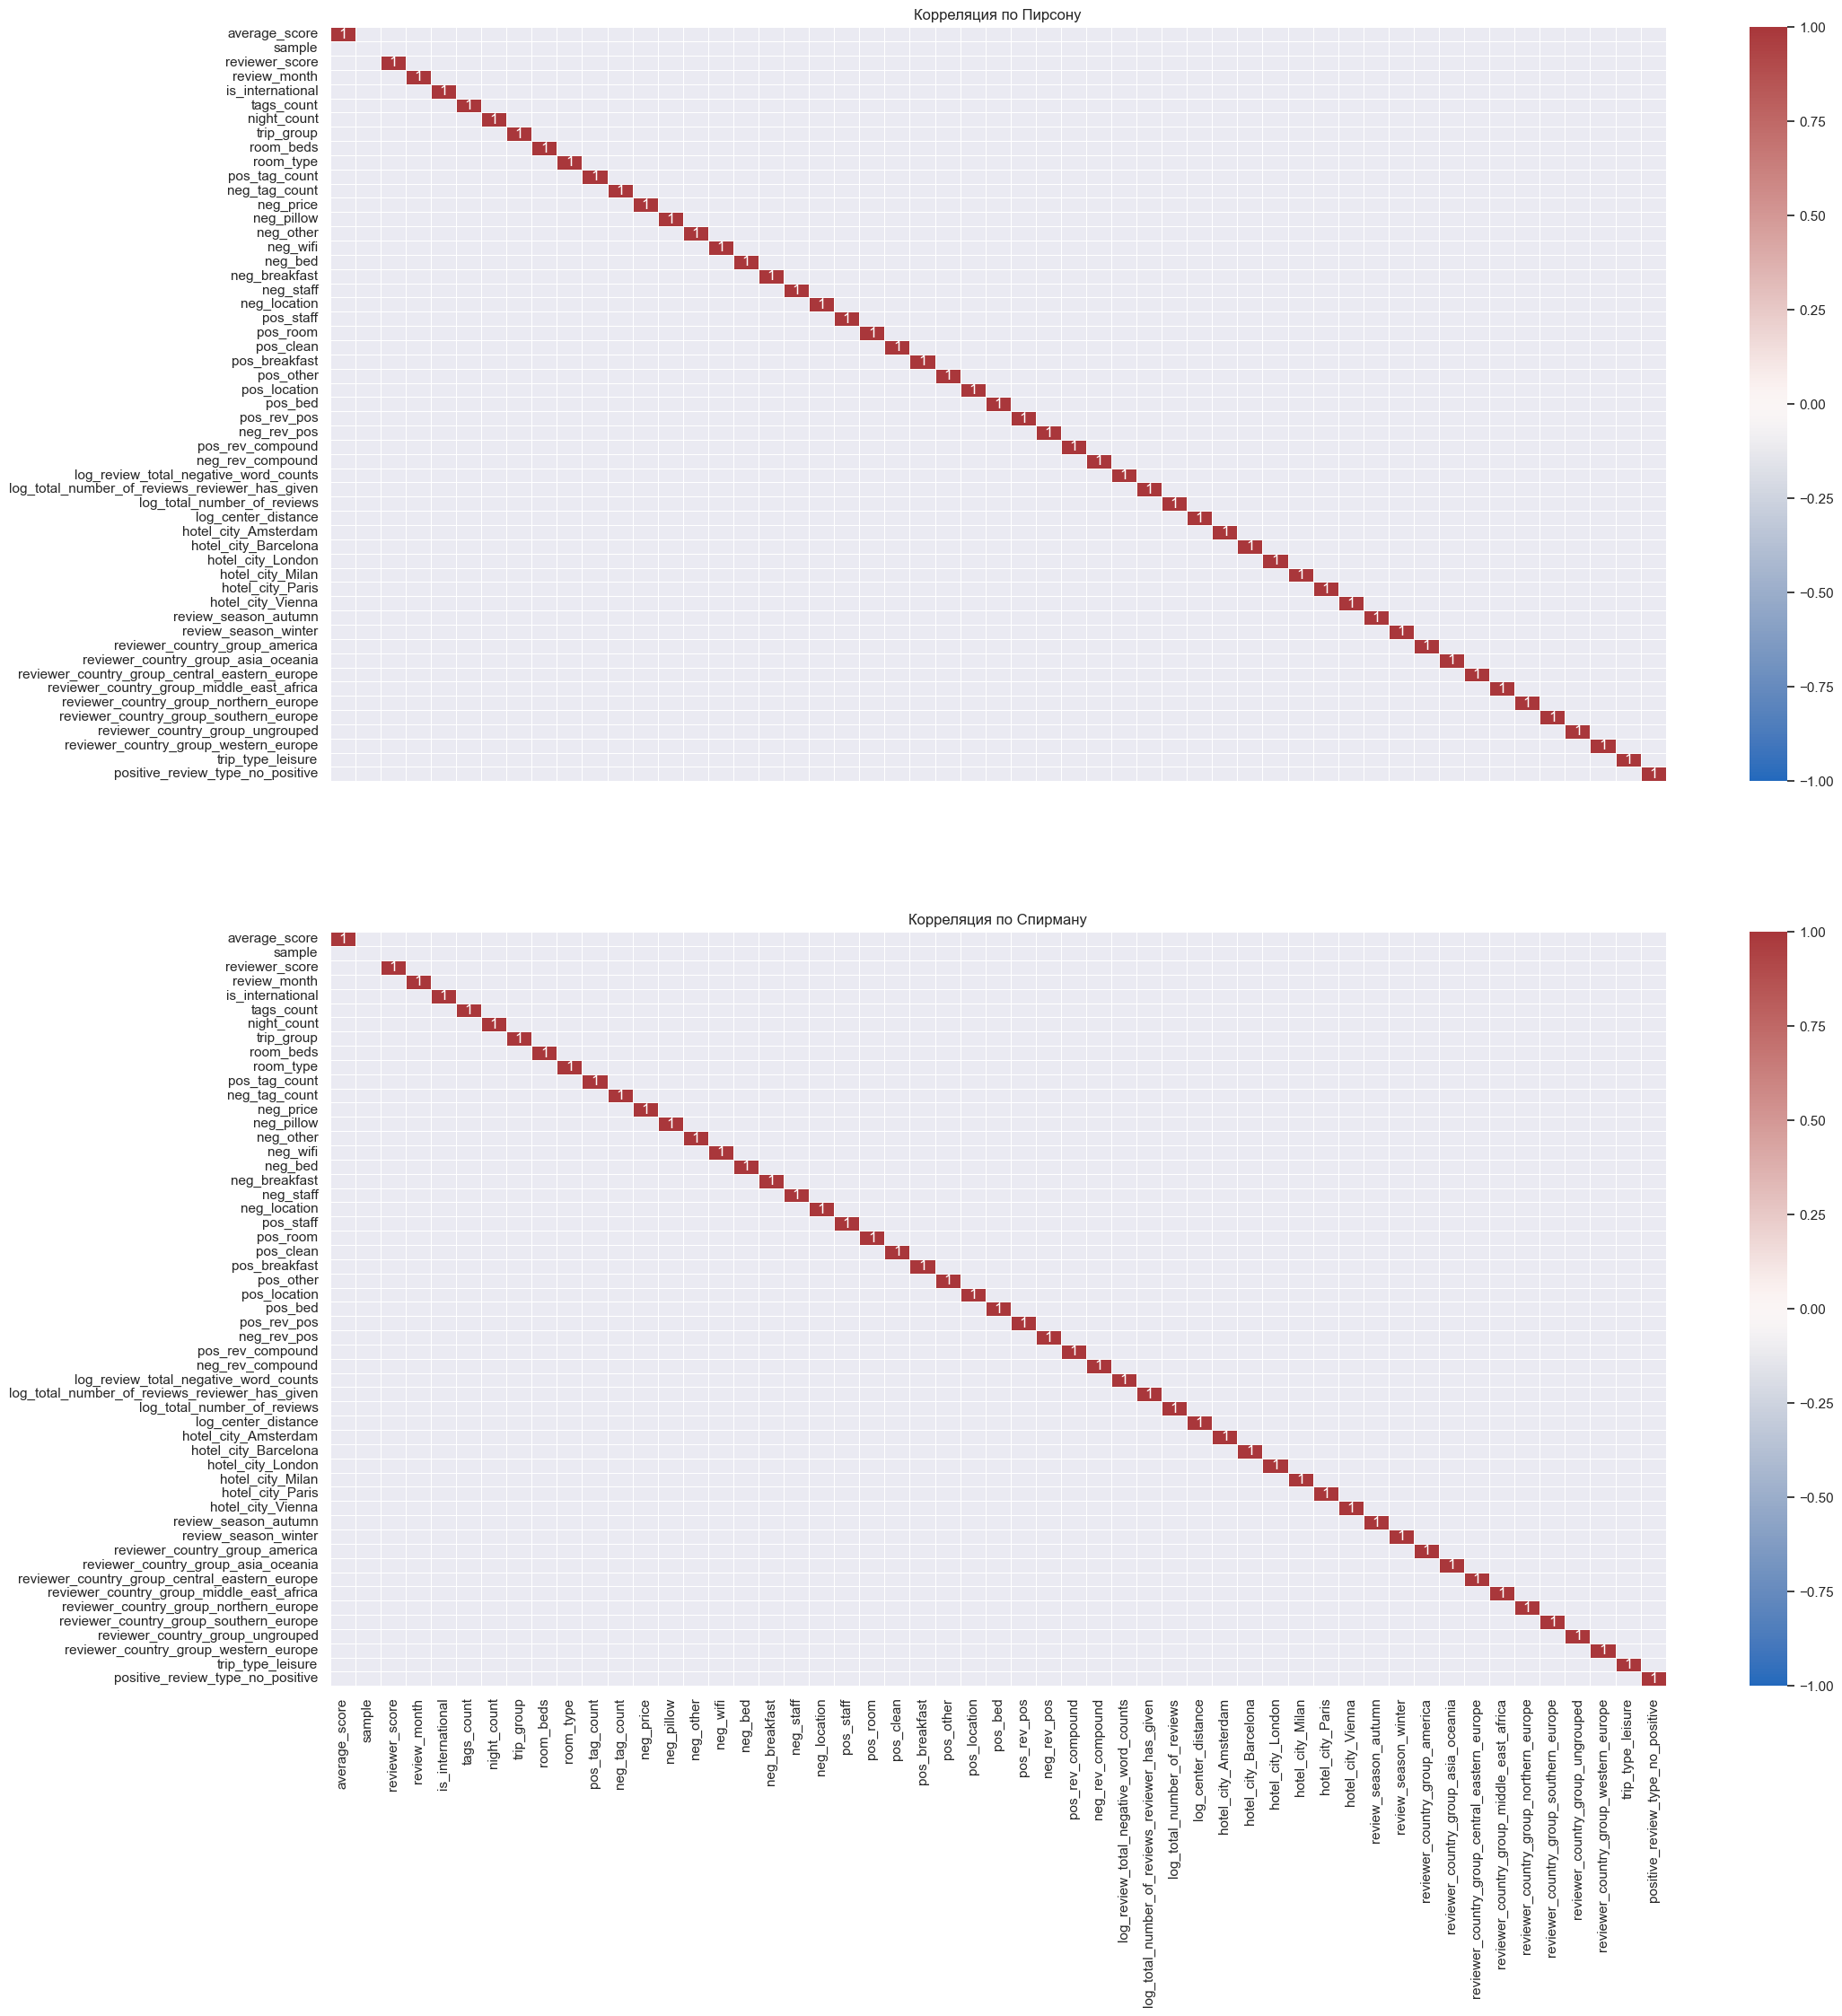

In [132]:
hotels = data.query('sample == 1')
# Убираем предупреждения
import warnings
warnings.filterwarnings("ignore")

pirson_corr = hotels.corr()
spearman_corr = hotels.corr(method='spearman')

# Строим корреляционные графики
fig, (pearson_axes, spearmen_axes) = plt.subplots(2,1, figsize=(24,24));
sns.heatmap(pirson_corr[abs(pirson_corr) >=0.7], vmin=-1, vmax=1, 
            annot=True, ax=pearson_axes, linewidths=.5, cmap="vlag");
sns.heatmap(spearman_corr[abs(spearman_corr) >=0.7], vmin=-1, vmax=1,\
    annot=True, ax=spearmen_axes, linewidths=.5, cmap="vlag");
# Настраиваем графики
pearson_axes.set_title('Корреляция по Пирсону');
pearson_axes.set_xticks([])
spearmen_axes.set_title('Корреляция по Спирману');

## 4. ML-Моделирование

**ОСНОВНЫЕ ЭТАПЫ:**
1. **Разделение набора данных:**
    - Возврат к двум датасетам - **df_train_test** и **df_predict**.
    Датасет **df_train_test** делится далее..
    - "по столбцам":
        - Признаки для обучения модели - **X**
        - Целевая переменная, которую будем предсказывать - **y**
    - "по строкам":
        - Тренировочный набор (**train**), для обучения модели
        - Тестовый набор (**test**), для оценки точности модели
2. **Создание (instant), обучение модели (fit) и предсказание значений (predict)**
Fit на train, predict на test
3. **Оценка качества модели**
    - с помощью метрик проверяется точность прогнозов, сделанных моделью.
4. **Финальное предсказание на df_predict**. С его помощью заполняется **submission.csv**, который и отправляется на проверку на Kaggle.

### 4.1. Разделение набора данных

Вернёмся к двум первоначальным датасетам

In [133]:
# Датасет для обучения и оценки качества
df_train_test = data.query('sample == 1').drop('sample', axis=1)\
    .reset_index(drop=True)
# Датасет для финального предсказания целевой функции, которая не известна
df_predict = data.query('sample == 0').drop('sample', axis=1)

Разбиваем датасет для обучения и оценки качества модели - **df_train_test**

In [134]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)
X = df_train_test.drop([TARGET_NAME], axis=1)
y = df_train_test[TARGET_NAME]

# Наборы данных с меткой "train" будут использоваться для обучения модели, 
# "test" — для тестирования.
# Для тестирования мы будем использовать 25 % от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,\
    random_state=RANDOM_STATE)

### 4.2. Создание и обучение модели

Примечание: 
- для корректной работы все данные в датафрейме, который используется при обучении модели, должны быть в числовых форматах int или float;
- в столбцах не должно быть пропущенных значений. Вместо каждого пропущенного значения вам нужно будет вычислить и поместить в ячейку максимально близкое к реальности значение.

In [135]:
# Создаём модель 
regr = RandomForestRegressor(n_estimators=N_ESTIMATORS)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой 
# выборке.  
# Предсказанные значения записываем в переменную y_pred 
y_pred = regr.predict(X_test)

### 4.3. Оценка качества модели

In [136]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим 
# насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает
# среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
train_mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print('MAPE:', train_mape)
# Запишем показатели метрики
metrics_to_publish = {
    'train_mape': train_mape
}
if 'experiment' in locals():
    experiment.log_metrics(metrics_to_publish)

MAPE: 0.12072080461315259


<AxesSubplot:>

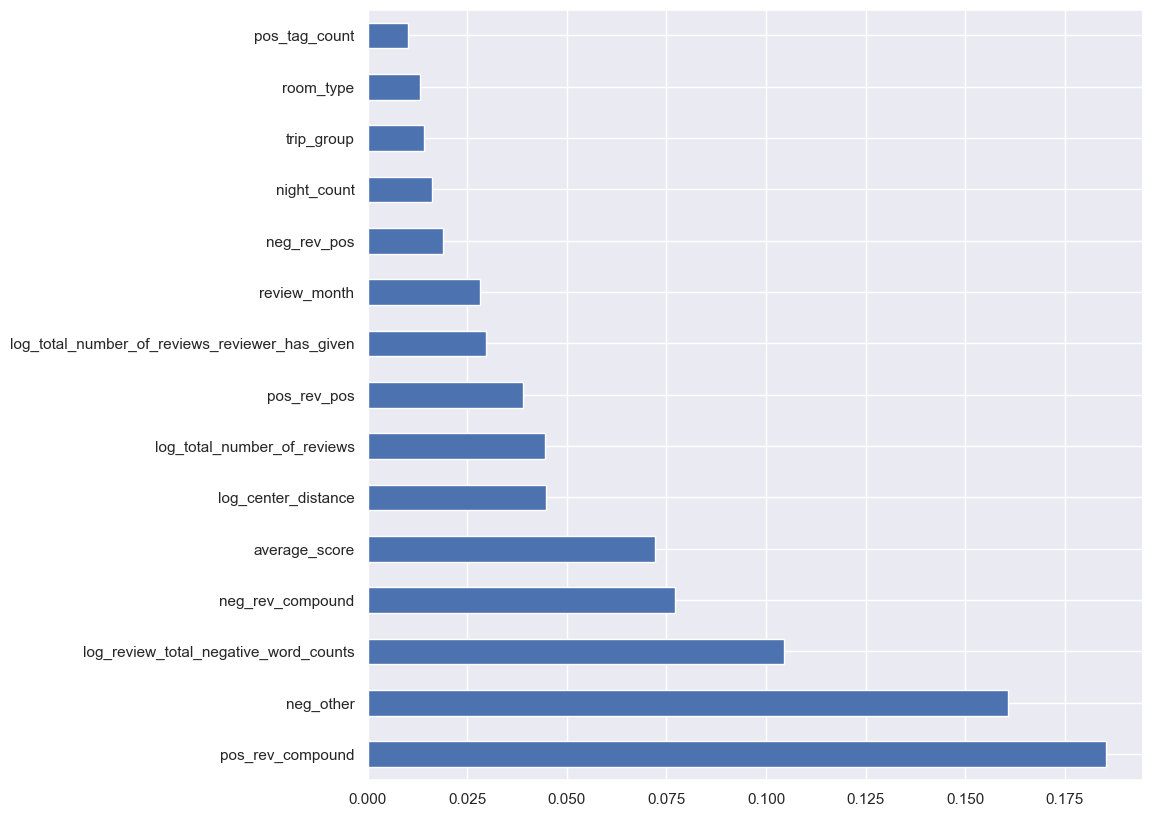

In [137]:
# выведем самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

### Завершение эксперимента

In [138]:
if 'experiment' in locals():
    experiment.end()
    del experiment

### Финальное предсказание
С сохранением в файл submission.csv

In [139]:
# Предсказание
df_predict[TARGET_NAME] = regr.predict(df_predict.drop([TARGET_NAME], axis=1))
# Сохранение в датасет для отправки
sample_submission['reviewer_score'] = df_predict[TARGET_NAME]
# Экспорт
sample_submission.to_csv('output/submission.csv', index=False)

### Валидация
В реальных проектах должна проводиться проверка того, что построенная модель 
решает поставленные бизнес задачи; что нет проблем бизнеса, 
которые не были рассмотрены.

На вход поступает уже построенная модель с высокой используемой метрикой, 
полученной на шаге моделирования.

После этого возможно внедрение модели (Model Deployment)

## 5. Заключение